# Coursework 2 - Neural Networks and Unsupervised Learning

__Name__: Georgios Alevras <br> __CID__: 01531221 <br> __Date__: 25/03/2022

<a name="outline"></a>

## Outline

- [Preliminaries](#preliminaries): Exploratory Data Analysis
- [Task 1](#task-1): Neural Networks
  - [1.1](#q11) Multi-Layer Perceptron (MLP)
  - [1.2](#q12) Convolutional Neural Network (CNN)
- [Task 2](#task-2): Unsupervised Learning
  - [2.1](#q21) Dimensionality Reduction and Clustering of a Subset of the Fashion-MNIST Image Data
  - [2.2](#q22) Clustering of the Feature Matrix
  - [2.3](#q23) Graph-Based Analysis
- [Task 3](#task-3): Mastery Component
  - [3.1](#q31) Non-Negative Matrix Factorization (NMF) for Dimensionality Reduction
  - [3.2](#q32) Community Detection

<a name="preliminaries"></a>
# Preliminaries: Exploratory Data Analysis [^](#outline)

Firstly, we import all the necessary Python packages to perform and execute all calculations and computations.

In [2]:
# All packages used in this coursework are imported here.
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Warning sign appears because I use Ubuntu and I haven't installed NVIDIA drivers so my GPU is not used.
import os
from IPython.display import Image

2022-03-23 14:00:34.144524: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-23 14:00:34.144547: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


We then import the dataset (both train and test data) using the function provided below, and perform an initial inspection of it, printing the shapes of each (x_train, y_train, x_test, y_test).

In [3]:
def load_data():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)  # convert labels to categorical samples
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
    return (x_train, y_train, x_test, y_test)

In [4]:
x_train, y_train, x_test, y_test = load_data()  # import the data
print('Shape of x_train:', x_train.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of x_test:', x_test.shape)
print('Shape of y_test:', y_test.shape)

Shape of x_train: (60000, 28, 28)
Shape of y_train: (60000, 10)
Shape of x_test: (10000, 28, 28)
Shape of y_test: (10000, 10)


We see that the training data consists of $60,000$ images of dimensions (pixels) $28$ by $28$ as our input data, and $60,000$ output vectors of size $10$, denoting the class output (what garment is depicted by each image, e.g., $0$ for T-shirt, $6$ for pullover, $3$ for dress, etc.). Similarly, the test data consists of $10,000$ images of the same dimensions as in the train data, and $10,000$ output vectors of size $10$, again, denoting the class output. To inspect further how they look, we depict a few examples below in *Figure 1*.

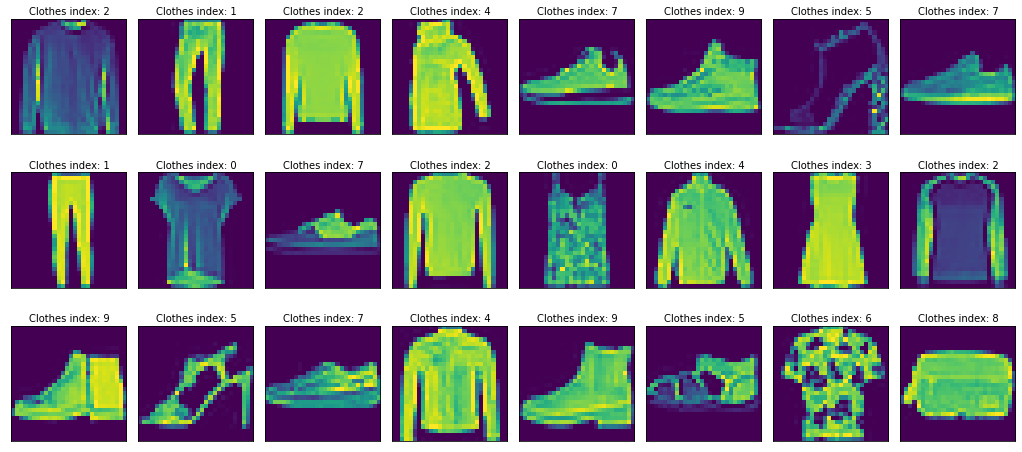

In [5]:
n_rows, n_cols = 3, 8
random_inx = np.random.choice(x_train.shape[0], n_rows * n_cols, replace=False)  # Selecting random data points from train data
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 8))
fig.subplots_adjust(hspace=0.2, wspace=0.1)

for n, i in enumerate(random_inx):
    row = n // n_cols
    col = n % n_cols
    axes[row, col].imshow(x_train[i])  # Visualising image
    axes[row, col].get_xaxis().set_visible(False)
    axes[row, col].get_yaxis().set_visible(False)
    axes[row, col].text(4., -1.5, f'Clothes index: {np.argmax(y_train[i])}')  # Categorising output by index of output vector
plt.show()

**Figure 1:** A set of $24$ randomly selected images from the train dataset with their class category written above each image, denoted by the index of the output (category) vector it belongs to.

Finally, we can explore the class distribution of the data by obtaining the number of pictures that belong to each class, as shown below.

In [6]:
number_of_images_per_class_train = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}  # dictionary to hold occurence of each class (clothes type)
for i in range(len(y_train)):
    number_of_images_per_class_train[np.argmax(y_train[i])] += 1

number_of_images_per_class_test = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}  # dictionary to hold occurence of each class (clothes type)
for i in range(len(y_test)):
    number_of_images_per_class_test[np.argmax(y_test[i])] += 1

for i in range(len(number_of_images_per_class_train.keys())-1):  # loops through all classes to check they are all equivalent
    assert(number_of_images_per_class_train[i] == number_of_images_per_class_train[i+1])  # ensuring occurences of all classes are equivalent
    assert(number_of_images_per_class_test[i] == number_of_images_per_class_test[i+1])  # ensuring occurences of all classes are equivalent

print('Number of each category of clothes (train):', number_of_images_per_class_train)
print('Number of each category of clothes (test):', number_of_images_per_class_test)

Number of each category of clothes (train): {0: 6000, 1: 6000, 2: 6000, 3: 6000, 4: 6000, 5: 6000, 6: 6000, 7: 6000, 8: 6000, 9: 6000}
Number of each category of clothes (test): {0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}


We can see that the two datasets are well-balanced, with an equal number of items belonging to each class both for our train and our test data, as was also verified from all assertions returning True. As a result of the dataset being well-balanced, we expect a baseline accuracy of 10% (1 over the number of classes), thus, if the MLP obtains an accuracy less than 10% the model would perform worse than picking at random, while any accuracy above 10% demonstrates that the MLP has at least some predictive power. Next, we build our Multi-Layer Perceptron.

<a name="task-1"></a>
# Task 1: Neural Networks [^](#outline)

<a name="q11"></a>

## 1.1 Multi-Layer Perceptron (MLP) [^](#outline)

<a name="q110a"></a>

#### 1.1.0.a Structure of MLP [^](#outline)

The Multi-Layer Perceptron (MLP) is a specific kind of feed-forward Artificial Neural Network (ANN) which consists of an input layer, an output layer and some number $L \in \mathbb{Z}^+$ of hidden layers, all of which are dense / fully-connected (all nodes in one layer are connected to all other nodes in the next layer). The MLP consists of the composition of many affine transformations, followed by the application of non-linear activation functions which operate element-wise. The architecture of the network can be fully described by the following equations:
$$\mathbf{h}^{(0)}:=\mathbf{x},$$
$$\mathbf{h}^{(k)}=\sigma \left( \mathbf{W}^{(k-1)}\mathbf{h}^{(k-1)} + \mathbf{b}^{(k-1)} \right), \quad k=1, \dots, L,$$
$$\mathbf{\hat{y}} = \sigma_\text{out}\left( \mathbf{w}^{(L)} + \mathbf{b}^{(L)} \right),$$

where $\mathbf{x} \in \mathbb{R}^D$ is an example input, $\mathbf{W}^{(k)} \in \mathbb{R}^{n_{k+1} \times n_k}$ is the matrix holding the weights between nodes of layer $n_k$ and $n_{k+1}$, $\mathbf{b}^{(k)} \in \mathbb{R}^{n_{k+1}}$ is the vector of biases added to the pre-activations $\mathbf{W}^{(k-1)}\mathbf{h}^{(k-1)} + \mathbf{b}^{(k-1)}$ at layer $k$, $\mathbf{h}^{(k)} \in \mathbb{R}^{n_{k}}$ is the vector of post-activation (or activation) values at layer $k$, $n_0 := D$, and $n_k$ is the number of nodes (neurons) at the $k$-th hidden layer. The activation function applied to the pre-activation values is $\sigma:\mathbb{R} \rightarrow \mathbb{R}$, while the activation function applied to the output values is $\sigma_\text{out}:\mathbb{R} \rightarrow \mathbb{R}$. Below is an illustration of an MLP.

<a name="q110b"></a>

#### 1.1.0.b Error Backpropagation [^](#outline)

Using the set of equations described above we can perform a forward pass on a data-point (or a set of data-points) to predict its output. However, initially, all the weights and biases are random - the MLP has not been trained. Therefore, we want to learn the model to make good predictions. We achieve this via ***error backpropagation*** through:
1. the computation of the *stochastic gradient of the loss function* with respect to the parameters (weights and biases) of the MLP
2. the update of the MLP parameters using the already-computed gradients

Once we have computed all gradients for all model parameters we can update them according to *stochastic gradient descent* as such:

$$\theta_{t+1}=\theta_t - \eta\nabla_t L(\theta_t;D_m), \quad t \in \mathbb{N}_0,$$

for each iteration $t$, where $\eta$ is the *learning rate* and the loss value $L$ is evaluated using a randomly sampled subset of the training data $\mathcal{D}_m$ called a ***batch***, where $|\mathcal{D}_m| \ll |\mathcal{D}_\text{train}|$. The loss value $L$ is the average loss value from all data-points in a batch $\mathcal{D}_m$:

$$L(\theta_t; \mathcal{D}_m)=\frac{1}{M}\sum_{x_i, y_i \in \mathcal{D}_m} l(y_i, f_{\theta_t}(x_i)),$$

where $f_{\theta_t}(x_i)$ is the MLP model, and $L_i := l(y_i, f_{\theta_t}(x_i))$ is the per-example (data-point) loss. Therefore, our goal is to compute all gradients (using the chain rule):

$$\frac{\partial{L_i}}{\partial{w_{pq}^{(k)}}}=\frac{\partial{L_i}}{\partial{a_p^{(k+1)}}}\frac{\partial{a_p^{(k+1)}}}{\partial{w_{pq}^{(k)}}},$$
$$\frac{\partial{L_i}}{\partial{b_p^{(k)}}}=\frac{\partial{L_i}}{\partial{a_p^{(k+1)}}}\frac{\partial{a_p^{(k+1)}}}{\partial{b_p^{(k)}}},$$

where $\mathbf{a}^{(k)}=\mathbf{W}^{(k-1)}\mathbf{h}^{(k-1)} + \mathbf{b}^{(k-1)}$ are the pre-activation values, which enable us to simplify the above equations as:

$$\frac{\partial{L_i}}{\partial{w_{pq}^{(k)}}}=\frac{\partial{L_i}}{\partial{a_p^{(k+1)}}}h_q^{(k)} =: \delta_p^{(k+1)}h_q^{(k)},$$
$$\frac{\partial{L_i}}{\partial{b_p^{(k)}}}=\frac{\partial{L_i}}{\partial{a_p^{(k+1)}}} =: \delta_p^{(k+1)},$$

where $\delta_p^{(k)} := \frac{\partial{L_i}}{\partial{a_p^{(k)}}}$. Next, we have to evaluate $\delta_p^{(k)}$:
$$\delta_p^{(k)}= \frac{\partial{L_i}}{\partial{a_p^{(k)}}} = \sum_{j=1}^{n_{k+1}} \frac{\partial{L_i}}{\partial{a_j^{(k+1)}}} \frac{\partial{a_j^{(k+1)}}}{\partial{a_p^{(k)}}} = \sum_{j=1}^{n_{k+1}} \delta_j^{(k+1)} \frac{\partial{a_j^{k+1}}}{\partial{a_p^{(k)}}}.$$

Knowing that: $a_j^{k+1}=\sum_{l=1}^{n_k} w_{jl}^{(k)}\sigma(a_l^{(k)}) + b_p^{(k)}$, we get: $\frac{\partial{a_j^{(k+1)}}}{\partial{a_p^{(k)}}}=w_{jp}^{(k)}\sigma'(a_p^{(k)})$, which means that:

$$\delta_p^k=\frac{\partial{L_i}}{\partial{a_p^{(k)}}} = \sum_{j=1}^{n_{k+1}} \delta_p^{(k+1)} \frac{\partial{a_j^{k+1}}}{\partial{a_p^{(k)}}}=\sigma'(a_p^{(k)}) \sum_{j=1}^{n_{k+1}} w_{jp}^{(k)}\delta_p^{(k+1)} = \sigma'(\mathbf{a}^{(k)})(\mathbf{W}^{(k)})^T \delta^{(k+1)},$$

where $\sigma'(\mathbf{a}^{(k)})=\text{diag}([\sigma'(a_p^{(k)})]_{p=1}^{n_k}).$ 

Therefore, in order for the MLP to learn, we need to:

1. Perform a forward pass of a batch of data-points through the MLP, computing and storing all pre-activations $\mathbf{a}^{(k)}$ and post-activations $\mathbf{h}^{(k)}$
2. Evaluate the errors on the output layer, $\delta^{(L+1)}=\frac{\partial{L_i}}{\partial{\mathbf{a}^{L+1}}}$
3. Backpropagate the errors for each layer using $\delta^{(k)}=\sigma'(\mathbf{a}^{(k)})(\mathbf{W}^{(k)})^T \delta^{(k+1)}$
4. Use the errors to obtain the derivaties of the per-example loss values: $\frac{\partial{L_i}}{\partial{w_{pq}^{(k)}}}=\delta_p^{(k+1)}h_q^{(k)}$, $\frac{\partial{L_i}}{\partial{b_p^{(k)}}}=\delta_p^{(k+1)}$
5. Update the MLP parameters using stochastic gradient descent: $\theta_{t+1}=\theta_t - \eta\nabla_t L(\theta_t;D_m)$

<a name="q110c"></a>

#### 1.1.0.c Architecture of MLP for this Task [^](#outline)

For this particular task we need to choose the architecture of the model; the number of hidden layers $L$, the number of nodes (neurons) in each layer (including the input and the output layers), the activation function $\sigma$, and the output activation function $\sigma_\text{out}$. Given the nature of our dataset, printed above, we naturally define the input layer to have $784 = 28 \times 28$ neurons, i.e., we flatten the 2D array of pixels for an image to get a 1D array which we define as $\mathbf{h}^0:=\mathbf{x}$, and we define our output layer to have $10$ neurons, one for each class. We then decide to have $5$ hidden layers, each with $400$ neurons; the layout of the MLP is demonstrated below in *Figure 2*.

![title](./Images/mlp_model.jpg)

**Figure 2:** Illustration of the architecture of the MLP used for **Task 1.1**, including the parameters at each layer and their dimensions.

Finally, we use $\text{LeakyReLU}(x)$ as the activation function for all layers except the output layer, for which we use the softmax function:

$$\text{LeakyReLU}(x)=\begin{cases} x, \quad x>0\\ \alpha x, \:\:\:x<=0\end{cases},$$

where $\alpha$ is a constant (in this case $\alpha=0.01$), and

$$\hat{\mathbf{y}}_j:=\text{softmax}(\mathbf{a}^{(L+1)})_j=\frac{\text{exp}(a_j)}{\sum_i \text{exp}(a_i)},$$

where $\mathbf{a}^{(L+1)}$ are the pre-activation values at the output layer, and $\hat{\mathbf{y}}$ is the vector of predicted probabilities for each class for a data-point.

Finally, the loss value for this MLP is obtained using the categorical cross-entropy loss function $L_\text{CE}$, which is given by:

$$L_\text{CE}=-\sum_{c=1}^C y_c \log{\hat{y}_c}, \quad \text{for} \: C \in \mathbb{N}_0 +1 \: \text{classes},$$

where $y_c$ is the ground truth for class $c$ and $\hat{y}_c$ is the softmax probability for class $c$. In order to be able to perform ***back-propagation*** we must be able to use the derivative functions of the activation functions, which are:

$$\text{LeakyReLU'}(x)=\begin{cases} 1, \quad x>0\\ \alpha, \:\:\:\:x<=0\end{cases},\\$$
$$\text{softmax'}(\mathbf{a}^{(L+1)})_j=\begin{cases} y_j(1-y_j), \quad i=j\\ -y_j y_i, \quad\:\:\:\:\:\:\:i \neq j\end{cases}.$$

In order to execute steps 2 and 3 outlined above, we want to find $\delta^{(L+1)}$, however, the derivative of the softmax function gives $\frac{\partial{\:\text{softmax}(\mathbf{a}^{(L+1)})_j}}{\partial{\mathbf{a}^{L+1}}}$. We can use the chain rule to obtain $\delta^{(L+1)}$ as such:

$$\delta^{(L+1)}_j=\sum_i \frac{\partial{L_\text{CE}}}{\partial{\:\text{softmax}(\mathbf{a}^{(L+1)})_i}}\frac{\partial{\:\text{softmax}(\mathbf{a}^{(L+1)})_i}}{\partial{\mathbf{a}^{L+1}}_j}$$

This result can be simplified significantly, as shown below:

$$
\quad\quad\quad\quad\: \delta^{(L+1)}_j=\frac{\partial{L_\text{CE}}}{\partial{\mathbf{a}^{L+1}}_j}=-\sum_i y_i  \frac{\partial{\log{\hat{y}_i}}}{\partial{\mathbf{a}^{L+1}}_j} \\
\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\:\:\:=-\sum_i y_i \frac{1}{\hat{y}_i}\frac{\partial{\hat{y}_i}}{\partial{\mathbf{a}^{L+1}}_j}, \quad \text{where} \:\: \hat{y}_i=\frac{\text{exp}(a_i^{L+1})}{\sum_j \text{exp}(a_j^{L+1})} \\
\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\:=-\sum_{i=j} y_i \frac{1}{\hat{y}_i} \hat{y}_i(1-\hat{y}_i) - \sum_{i\neq j} y_i \frac{1}{\hat{y}_i} (-\hat{y}_i\hat{y}_j) \\
\quad\quad\quad\quad\quad\quad\:= -y_j(1-\hat{y}_j) + \sum_{i\neq j} y_i \frac{\hat{y}_i \hat{y}_j}{\hat{y}_i} \\
\quad\quad\quad\quad\:\:\:\:=-y_j + y_j \hat{y}_j + \sum_{i \neq j} y_i \hat{y}_j \\
\quad\quad\quad\:=\hat{y}_j \left( \sum_i y_i \right) - y_j \\
=\hat{y}_j - y_j \\
$$

Therefore, $\delta^{(L+1)}=\hat{\mathbf{y}} - \mathbf{y}$. As a result, we don't need to write a softmax derivative function; the error at the output layer can be simply written as $\delta^{(L+1)}=\hat{\mathbf{y}} - \mathbf{y}$. The activation functions, their derivative functions and softmax are outlined below.

In [7]:
def leakyrelu(x, alpha=0.01):
    # Returns x if x>0 and alpha*x if x<=0
	return x*(x>alpha) + alpha*x*(x<=alpha)

def leakyrelu_prime(x, alpha=0.01):
    # Returns 1 if x>0 and alpha if x<0
    return np.ones(x.shape)*(x>0) + alpha*(x<0)

def softmax(y):
    e = np.exp(y)  # exponentiates all output vectors y for each value in a batch
    sums = np.sum(e, axis=1)  # sums of each output vector y for each value in a batch
    return e*1/sums[:, np.newaxis]  # Divides exponentiated output vector y with corresponding sum

def cross_entropy(y, y_hat, e=1e-7):
    # Categorical cross-entropy used as loss function
    values = -y*np.log(y_hat+e)  # Small error added to avoid infinity / NaN issues when evaluating logs at 0
    return np.sum(values, axis=1)

Next, we use a class to build the MLP. The biases are initialised as zeros, while the weights are initialised from a Gaussian distribution $\mathcal{N}\left(0, \frac{2}{(n_{k}+n_{k+1})}\right)$ with $0$ mean and variance $2/(n_{k}+n_{k+1})$, where $n_{k}$ and $n_{k+1}$ are the number of neurons at the $k$-th and $(k+1)$-th layers respectively, which is the ***Glorot Initialisation***.

In addition, a subtlety that needs to be mentioned is how the algorithms for the forward pass and error backpropagation have been tweaked in order to allow to pass batches of data at once. For the most part, the vectors and matrices are simply expanded with an additional dimension to include the values for each data-point. However, this only works when matrix multiplication is desirable. In the case of outer products, we want to ensure that there is no cross-multiplication between different data-points. Therefore, in the case of $\frac{\partial{L_i}}{\partial{w_{pq}^l}}=\delta_p^{l+1}h_q^l$, we add an aditional axis to each variable to perform the outer product over the correct dimensions, as such: 

```Python 
self.grad_weights[k] = np.matmul(self.d[k][:, :, np.newaxis], self.h[k][:, np.newaxis, :]).mean(axis=0)
``` 

and then take the average value over all data-points in the batch to update the parameters. As a result, we perform a forward pass and an error-backpropagation with batches of $256$ points, making a single parameter update by averaging the gradients obtained from the $256$ data-points. Next, we obtain a batch (iteration) loss and accuracy by averaging the loss and accuracy of the $256$ data-points. Finally, once we have gone through the entire dataset using $\lceil \frac{N}{M} \rceil$ batches (for $N$ data-points and $M$-sized batches) we perform a forward pass and an error back-propagation of the entire dataset using the model parameters last obtained from the last batch, to obtain an accuracy and loss value for one epoch - defined as the time unit of having gone through the entire dataset.

The MLP is outlined below.

In [8]:
class MLP():
    def __init__(self, mlp_configuration):
        self.config = mlp_configuration  # Configuration of MLP (# of neurons in each layer)
        self.hidden_layers = len(mlp_configuration) - 2  # Number of hidden layers
        # Weights between successive layers, initialised from a Gaussian
        self.weights = [np.random.normal(size=(mlp_configuration[k+1], mlp_configuration[k])) * np.sqrt(2./(mlp_configuration[k]+mlp_configuration[k+1])) for k in range(len(mlp_configuration)-1)]
        # Biases added to each layer to perform pre-activation
        self.biases = [np.zeros((mlp_configuration[k+1])) for k in range(len(mlp_configuration)-1)]
        self.a = [None for _ in range(len(mlp_configuration)-1)]  # Pre-activations
        self.h = [None for _ in range(len(mlp_configuration))]  # (Post) Activations
        self.d = [None for _ in range(len(mlp_configuration)-1)]  # Deltas - errors at each node
        self.grad_weights = [None for _ in range(len(mlp_configuration)-1)]  # Weights gradients
        self.grad_biases = [None for _ in range(len(mlp_configuration)-1)]  # Biases gradients
        self.batch_losses = []  # Will hold the batch (iteration) losses
        self.batch_accuracies = []  # Will hold the batch (iteration) accuracies
        self.epoch_losses = []  # Will hold the epoch losses
        self.epoch_accuracies = []  # Will hold the epoch accuracies
        self.test_epoch_losses = []  # Will hold the epoch test losses
        self.test_epoch_accuracies = []  # Will hold the epoch test accuracies

        
    def __str__(self):
        weights_shapes = [self.weights[i].shape for i in range(len(self.weights))]  # Shape of weights array
        biases_shapes = [self.biases[i].shape for i in range(len(self.biases))]  # Shape of biases array
        return "\nMLP Characteristics:\n--------------------\nMLP Configuration: {}\nWeights shapes: {} \
            \nBiases shapes: {}\n".format(self.config, weights_shapes, biases_shapes)
    
    
    def forward_pass(self, x):
        self.h[0] = x  # Initialise first activations to neurons of input layer (input data)
        for k in range(self.hidden_layers):  # Loop through all hidden layers
            self.a[k] = np.matmul(self.weights[k], self.h[k].T).T + self.biases[k]  # Compute pre-activations
            self.h[k+1] = leakyrelu(self.a[k])  # Apply activation function (leaky RELU) to get (post) activations
        self.a[-1] = np.matmul(self.weights[-1], self.h[-2].T).T + self.biases[-1]  # Compute pre-activations for output layer
        self.h[-1] = softmax(self.a[-1])  # Apply output-activation function (softmax) to get output values

        
    def backpropagate_errors(self, y):
        self.d[-1] = self.h[-1] - y  # Get output errors using softmax and categorical cross-entropy
        for k in reversed(range(self.hidden_layers)):  # Loop through all hidden layers in reverse
            self.d[k] = leakyrelu_prime(self.a[k]) * (self.weights[k+1].T @ self.d[k+1].T).T  # Backpropagate errors
            
            
    def update_params(self, learning_rate):
        for k in range(self.hidden_layers+1):  # Loop through all layers (except output)
            # Taking the average weight gradients over all inputs in a batch (outer product for 3D matrix)
            self.grad_weights[k] = np.matmul(self.d[k][:, :, np.newaxis], self.h[k][:, np.newaxis, :]).mean(axis=0)
            self.grad_biases[k] = self.d[k].mean(axis=0)  # Compute biases gradients using deltas
            self.weights[k] -= learning_rate*self.grad_weights[k]  # Update weights with learning rate
            self.biases[k] -= learning_rate*self.grad_biases[k]  # Update biases with learning rate

            
    def make_prediction(self, x, y_t):
        # Perform a forward pass to obtain a prediction on a batch of input data
        values = x  # Initialise first activations to input nodes (input data)
        for k in range(self.hidden_layers):  # Loop through all hidden layers
            values = np.matmul(self.weights[k], values.T).T + self.biases[k]  # Compute pre-activations
            values = leakyrelu(values)  # Apply activation function (leaky RELU) to get (post) activations
        final_values = np.matmul(self.weights[-1], values.T).T + self.biases[-1]  # Compute pre-activations for output layer
        final_values = softmax(final_values)  # Apply output-activation function (softmax) to get output nodes
        
        crs_entr = cross_entropy(y_t, final_values)  # Obtain loss value (categorical cross-entropy)
        prediction = np.zeros((final_values.shape))  # Array to convert probabilities to class prediction
        successful = np.zeros((final_values.shape[0]))  # Array to hold successful predictions for each datum
        for p in range(len(prediction)):  # Looping through all data-points in a batch
            prediction[p][np.argmax(final_values[p])] = 1  # Assign the predicted class to the highest probability
            # Assign as succesful prediction if it the same as that of the ground truth
            successful[p] = [1 if np.all(prediction[p] == y_t[p]) else 0][0]
        return np.mean(crs_entr), np.mean(successful)  # Return batch-average loss and accuracy

    
    def train(self, x_train, y_train, x_test, y_test, learning_rate=1e-3, batch_size=256, epochs=40):
        for e in range(epochs):
            p = np.random.permutation(len(x_train))  # Randomise indices of all data
            random_indices = [p[idx:idx+batch_size] for idx in range(0, len(p), batch_size)]  # Create random batch indices
            for rnd_idx in random_indices:  # Loop through batch indices
                x_batch, y_batch = x_train[rnd_idx], y_train[rnd_idx]  # Create batches of X and Y data
                self.forward_pass(x_batch)  # Perform forward pass on batch of data
                self.backpropagate_errors(y_batch)  # Perform backprogatation of errors on batch of data
                self.update_params(learning_rate)  #  Update MLP parameters (weights, biases) after error backpropagation
                batch_loss, batch_accuracy = self.make_prediction(x_batch, y_batch)  # Obtain batch loss and accuracy
                self.batch_accuracies.append(batch_accuracy)
                self.batch_losses.append(batch_loss)
            
            epoch_loss, epoch_accuracy = self.make_prediction(x_train, y_train)  # Obtain epoch loss and accuracy on train data
            self.epoch_losses.append(epoch_loss)
            self.epoch_accuracies.append(epoch_accuracy)
            test_loss, test_accuracy = self.make_prediction(x_test, y_test)  # Obtain epoch loss and accuracy on test data
            self.test_epoch_losses.append(test_loss)
            self.test_epoch_accuracies.append(test_accuracy)
        print('Training Complete.\n')
            

    def save_results(self, learning_rate=1e-3, batch_size=256, epochs=40):
        np.save(os.path.join('npy_objects', 'epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)), np.array(self.epoch_accuracies))
        np.save(os.path.join('npy_objects', 'test_epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)), np.array(self.test_epoch_accuracies))
        np.save(os.path.join('npy_objects', 'epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)), np.array(self.epoch_losses))
        np.save(os.path.join('npy_objects', 'test_epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)), np.array(self.test_epoch_losses))
        np.save(os.path.join('npy_objects', 'batch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)), np.array(self.batch_accuracies))
        np.save(os.path.join('npy_objects', 'batch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)), np.array(self.batch_losses))

First, we flatten the 2D array of pixels for an image to get the 1D array to be used as values of the input layer.

In [9]:
n_input = x_train.shape[-1]**2  # making each image pixel into a feature
x_train = x_train.reshape(len(x_train), n_input)  # flattening each datum array into a 1D array
x_test = x_test.reshape(len(x_test), n_input)  # flattening each datum array into a 1D array
n_classes = y_train.shape[1]  # number of classes 

<a name="q111"></a>

#### Task 1.1.1 [^](#outline)

For the first task we train the MLP on batches of $256$ data-points for $40$ epochs, using a learning rate of $10^{-3}$.

In [9]:
# determining the hyper-parameters
learning_rate = 1e-3
batch_size = 256
epochs = 40

# determining the structure of the MLP network
mlp_config = (n_input, 400, 400, 400, 400, 400, n_classes)
mlp = MLP(mlp_config)
print(mlp)
mlp.train(x_train, y_train, x_test, y_test, learning_rate=learning_rate, batch_size=batch_size, epochs=epochs)
mlp.save_results(learning_rate=learning_rate, batch_size=batch_size, epochs=epochs)


MLP Characteristics:
--------------------
MLP Configuration: (784, 400, 400, 400, 400, 400, 10)
Weights shapes: [(400, 784), (400, 400), (400, 400), (400, 400), (400, 400), (10, 400)]             
Biases shapes: [(400,), (400,), (400,), (400,), (400,), (10,)]

Training Complete.



Next we plot the loss function value and the accuracy obtained from the MLP as a function of the number of epochs with the above set of hyper-parameters: $\text{epochs}=40$, $\text{batch-size}=256$, $\text{learning rate}=\eta=10^{-3}$, for both the training and the test data, as shown in *Figure 3*.

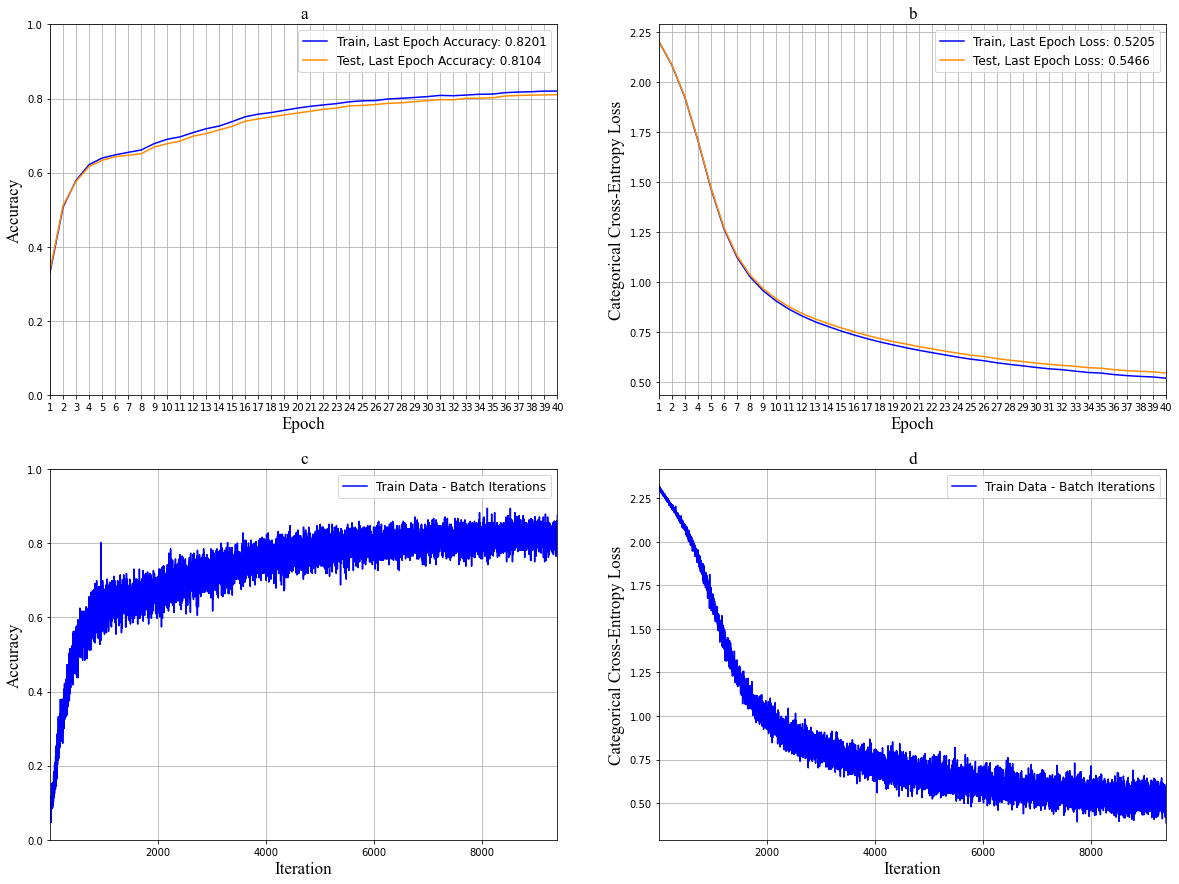

In [392]:
learning_rate = 1e-3
batch_size = 256
epochs = 40

epoch_accuracies = np.load('./npy_objects/epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
test_epoch_accuracies = np.load('npy_objects/test_epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
epoch_losses = np.load('npy_objects/epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
test_epoch_losses = np.load('npy_objects/test_epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
batch_accuracies = np.load('npy_objects/batch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
batch_losses = np.load('npy_objects/batch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)

from matplotlib.ticker import FormatStrFormatter
params = {'legend.fontsize': 12}
plt.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'

fig, axs = plt.subplots(2, 2, figsize=(20,15))
axs[0,0].plot(np.linspace(1, len(epoch_accuracies), len(epoch_accuracies)), epoch_accuracies, color='blue', label='Train, Last Epoch Accuracy: {}'.format(round(epoch_accuracies[-1], 4)))
axs[0,0].plot(np.linspace(1, len(test_epoch_accuracies), len(test_epoch_accuracies)), test_epoch_accuracies, color='darkorange', label='Test, Last Epoch Accuracy: {}'.format(round(test_epoch_accuracies[-1], 4)))
axs[0,0].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[0,0].set_ylabel('Accuracy', fontname='Times New Roman', fontsize=17)
axs[0,0].set_title('a', fontname='Times New Roman', fontsize=17)
axs[0,0].set_xlim(1, len(test_epoch_accuracies))
axs[0,0].set_xticks(np.linspace(1, len(epoch_accuracies), len(epoch_accuracies)))
axs[0,0].set_ylim(0, 1)
axs[0,0].grid()
axs[0,0].legend()

axs[0,1].plot(np.linspace(1, len(epoch_losses), len(epoch_losses)), epoch_losses, color='blue', label='Train, Last Epoch Loss: {}'.format(round(epoch_losses[-1], 4)))
axs[0,1].plot(np.linspace(1, len(test_epoch_losses), len(test_epoch_losses)), test_epoch_losses, color='darkorange', label='Test, Last Epoch Loss: {}'.format(round(test_epoch_losses[-1], 4)))
axs[0,1].set_title('b', fontname='Times New Roman', fontsize=17)
axs[0,1].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[0,1].set_ylabel('Categorical Cross-Entropy Loss', fontname='Times New Roman', fontsize=17)
axs[0,1].set_xlim(1, len(test_epoch_losses))
axs[0,1].set_xticks(np.linspace(1, len(epoch_losses), len(epoch_losses)))
axs[0,1].grid()
axs[0,1].legend()

axs[1,0].plot(np.linspace(1, len(batch_accuracies), len(batch_accuracies)), batch_accuracies, color='blue', label='Train Data - Batch Iterations')
axs[1,0].set_title('c', fontname='Times New Roman', fontsize=17)
axs[1,0].set_xlabel('Iteration', fontname='Times New Roman', fontsize=17)
axs[1,0].set_ylabel('Accuracy', fontname='Times New Roman', fontsize=17)
axs[1,0].set_xlim(1, len(batch_accuracies))
axs[1,0].set_ylim(0, 1)
axs[1,0].grid()
axs[1,0].legend()

axs[1,1].plot(np.linspace(1, len(batch_losses), len(batch_losses)), batch_losses, color='blue', label='Train Data - Batch Iterations')
axs[1,1].set_title('d', fontname='Times New Roman', fontsize=17)
axs[1,1].set_xlabel('Iteration', fontname='Times New Roman', fontsize=17)
axs[1,1].set_ylabel('Categorical Cross-Entropy Loss', fontname='Times New Roman', fontsize=17)
axs[1,1].set_xlim(1, len(batch_losses))
axs[1,1].grid()
axs[1,1].legend()

plt.show()

**Figure 3:** a) Accuracy of MLP as a function of epoch for train data (blue) and test data (orange). b) Categorical cross-entropy loss function value of MLP as a function of epoch for train data (blue) and test data (orange). c) Accuracy of MLP as a function of batch iteration for train data. d) Categorical cross-entropy loss function value of MLP as a function of batch iteration for train data. For all plots, the following hyper-parameters were used: $\text{epochs}=40$, $\text{batch-size}=256$, $\text{learning rate}=\eta=10^{-3}$.

<a name="q112"></a>

#### Task 1.1.2 [^](#outline)

For the first task we train the MLP on batches of $256$ data-points for $40$ epochs, but this time using learning rates of i) $10^{-5}$ and ii) $10^{-1}$. First we train the MLP model using a learning rate of $10^{-5}$ shown below.

In [11]:
# determining the hyper-parameters
learning_rate = 1e-5
batch_size = 256
epochs = 40

# determining the structure of the MLP network
mlp_config = (n_input, 400, 400, 400, 400, 400, n_classes)
mlp = MLP(mlp_config)
print(mlp)
mlp.train(x_train, y_train, x_test, y_test, learning_rate=learning_rate, batch_size=batch_size, epochs=epochs)
mlp.save_results(learning_rate=learning_rate, batch_size=batch_size, epochs=epochs)


MLP Characteristics:
--------------------
MLP Configuration: (784, 400, 400, 400, 400, 400, 10)
Weights shapes: [(400, 784), (400, 400), (400, 400), (400, 400), (400, 400), (10, 400)]             
Biases shapes: [(400,), (400,), (400,), (400,), (400,), (10,)]

Training Complete.



Next we train the MLP model using a learning rate of $10^{-1}$ shown below.

In [12]:
# determining the hyper-parameters
learning_rate = 1e-1
batch_size = 256
epochs = 40

# determining the structure of the MLP network
mlp_config = (n_input, 400, 400, 400, 400, 400, n_classes)
mlp = MLP(mlp_config)
print(mlp)
mlp.train(x_train, y_train, x_test, y_test, learning_rate=learning_rate, batch_size=batch_size, epochs=epochs)
mlp.save_results(learning_rate=learning_rate, batch_size=batch_size, epochs=epochs)


MLP Characteristics:
--------------------
MLP Configuration: (784, 400, 400, 400, 400, 400, 10)
Weights shapes: [(400, 784), (400, 400), (400, 400), (400, 400), (400, 400), (10, 400)]             
Biases shapes: [(400,), (400,), (400,), (400,), (400,), (10,)]

Training Complete.



Next we plot the loss function value and the accuracy obtained from the MLP as a function of the number of epochs with the above set of hyper-parameters: $\text{epochs}=40$, $\text{batch-size}=256$, $\text{learning rate}=\eta=10^{-5}$, for both the training and the test data, as shown in *Figure 4*.

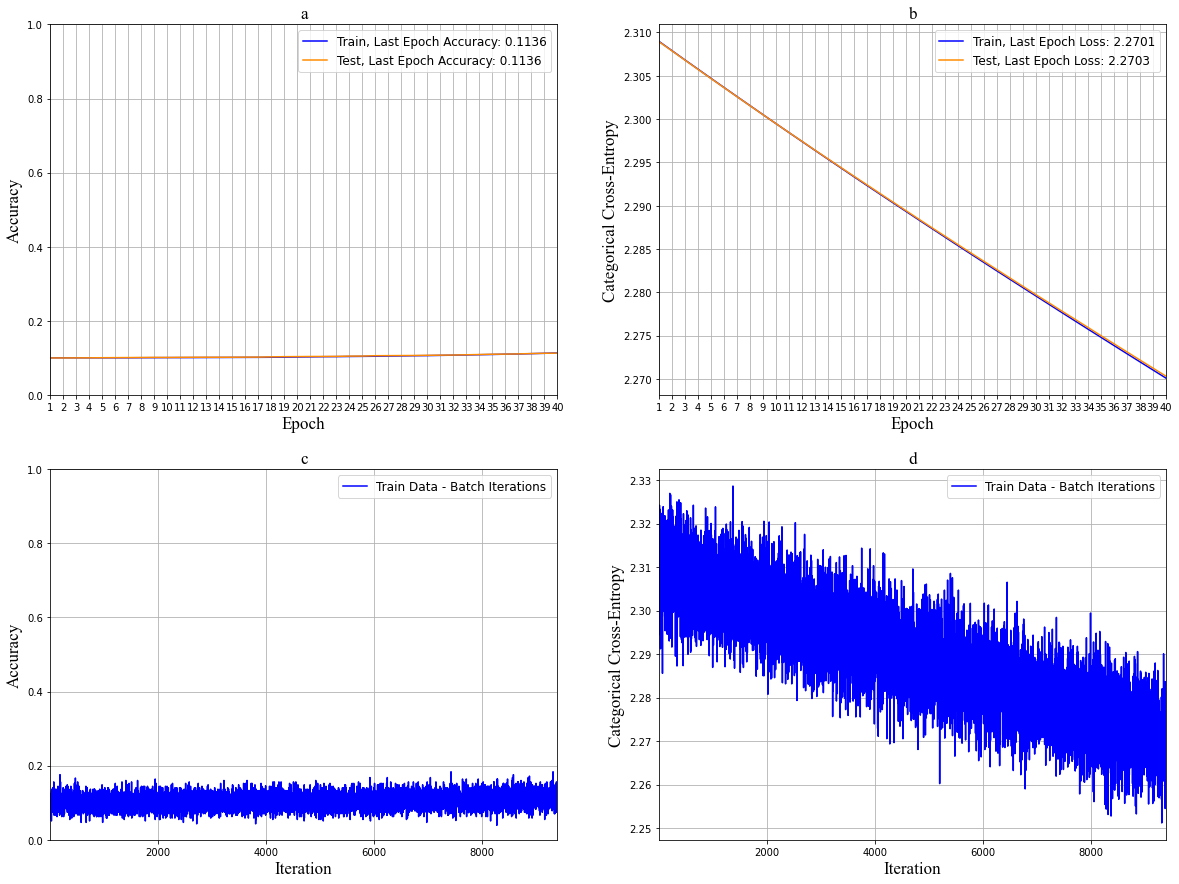

In [393]:
learning_rate = 1e-5
batch_size = 256
epochs = 40

epoch_accuracies = np.load('./npy_objects/epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
test_epoch_accuracies = np.load('npy_objects/test_epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
epoch_losses = np.load('npy_objects/epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
test_epoch_losses = np.load('npy_objects/test_epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
batch_accuracies = np.load('npy_objects/batch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
batch_losses = np.load('npy_objects/batch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)

from matplotlib.ticker import FormatStrFormatter
params = {'legend.fontsize': 12}
plt.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'

fig, axs = plt.subplots(2, 2, figsize=(20,15))
axs[0,0].plot(np.linspace(1, len(epoch_accuracies), len(epoch_accuracies)), epoch_accuracies, color='blue', label='Train, Last Epoch Accuracy: {}'.format(round(epoch_accuracies[-1], 4)))
axs[0,0].plot(np.linspace(1, len(test_epoch_accuracies), len(test_epoch_accuracies)), test_epoch_accuracies, color='darkorange', label='Test, Last Epoch Accuracy: {}'.format(round(epoch_accuracies[-1], 4)))
axs[0,0].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[0,0].set_ylabel('Accuracy', fontname='Times New Roman', fontsize=17)
axs[0,0].set_title('a', fontname='Times New Roman', fontsize=17)
axs[0,0].set_xlim(1, len(test_epoch_accuracies))
axs[0,0].set_xticks(np.linspace(1, len(epoch_accuracies), len(epoch_accuracies)))
axs[0,0].set_ylim(0, 1)
axs[0,0].grid()
axs[0,0].legend()

axs[0,1].plot(np.linspace(1, len(epoch_losses), len(epoch_losses)), epoch_losses, color='blue', label='Train, Last Epoch Loss: {}'.format(round(epoch_losses[-1], 4)))
axs[0,1].plot(np.linspace(1, len(test_epoch_losses), len(test_epoch_losses)), test_epoch_losses, color='darkorange', label='Test, Last Epoch Loss: {}'.format(round(test_epoch_losses[-1], 4)))
axs[0,1].set_title('b', fontname='Times New Roman', fontsize=17)
axs[0,1].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[0,1].set_ylabel('Categorical Cross-Entropy', fontname='Times New Roman', fontsize=17)
axs[0,1].set_xlim(1, len(test_epoch_losses))
axs[0,1].set_xticks(np.linspace(1, len(epoch_losses), len(epoch_losses)))
axs[0,1].grid()
axs[0,1].legend()

axs[1,0].plot(np.linspace(1, len(batch_accuracies), len(batch_accuracies)), batch_accuracies, color='blue', label='Train Data - Batch Iterations')
axs[1,0].set_title('c', fontname='Times New Roman', fontsize=17)
axs[1,0].set_xlabel('Iteration', fontname='Times New Roman', fontsize=17)
axs[1,0].set_ylabel('Accuracy', fontname='Times New Roman', fontsize=17)
axs[1,0].set_xlim(1, len(batch_accuracies))
axs[1,0].set_ylim(0, 1)
axs[1,0].grid()
axs[1,0].legend()

axs[1,1].plot(np.linspace(1, len(batch_losses), len(batch_losses)), batch_losses, color='blue', label='Train Data - Batch Iterations')
axs[1,1].set_title('d', fontname='Times New Roman', fontsize=17)
axs[1,1].set_xlabel('Iteration', fontname='Times New Roman', fontsize=17)
axs[1,1].set_ylabel('Categorical Cross-Entropy', fontname='Times New Roman', fontsize=17)
axs[1,1].set_xlim(1, len(batch_losses))
axs[1,1].grid()
axs[1,1].legend()

plt.show()

**Figure 4:** a) Accuracy of MLP as a function of epoch for train data (blue) and test data (orange). b) Categorical cross-entropy loss function value of MLP as a function of epoch for train data (blue) and test data (orange). c) Accuracy of MLP as a function of batch iteration for train data. d) Categorical cross-entropy loss function value of MLP as a function of batch iteration for train data. For all plots, the following hyper-parameters were used: $\text{epochs}=40$, $\text{batch-size}=256$, $\text{learning rate}=\eta=10^{-5}$.

Next we plot the loss function value and the accuracy obtained from the MLP as a function of the number of epochs with the above set of hyper-parameters: $\text{epochs}=40$, $\text{batch-size}=256$, $\text{learning rate}=\eta=10^{-1}$, for both the training and the test data, as shown in *Figure 5*.

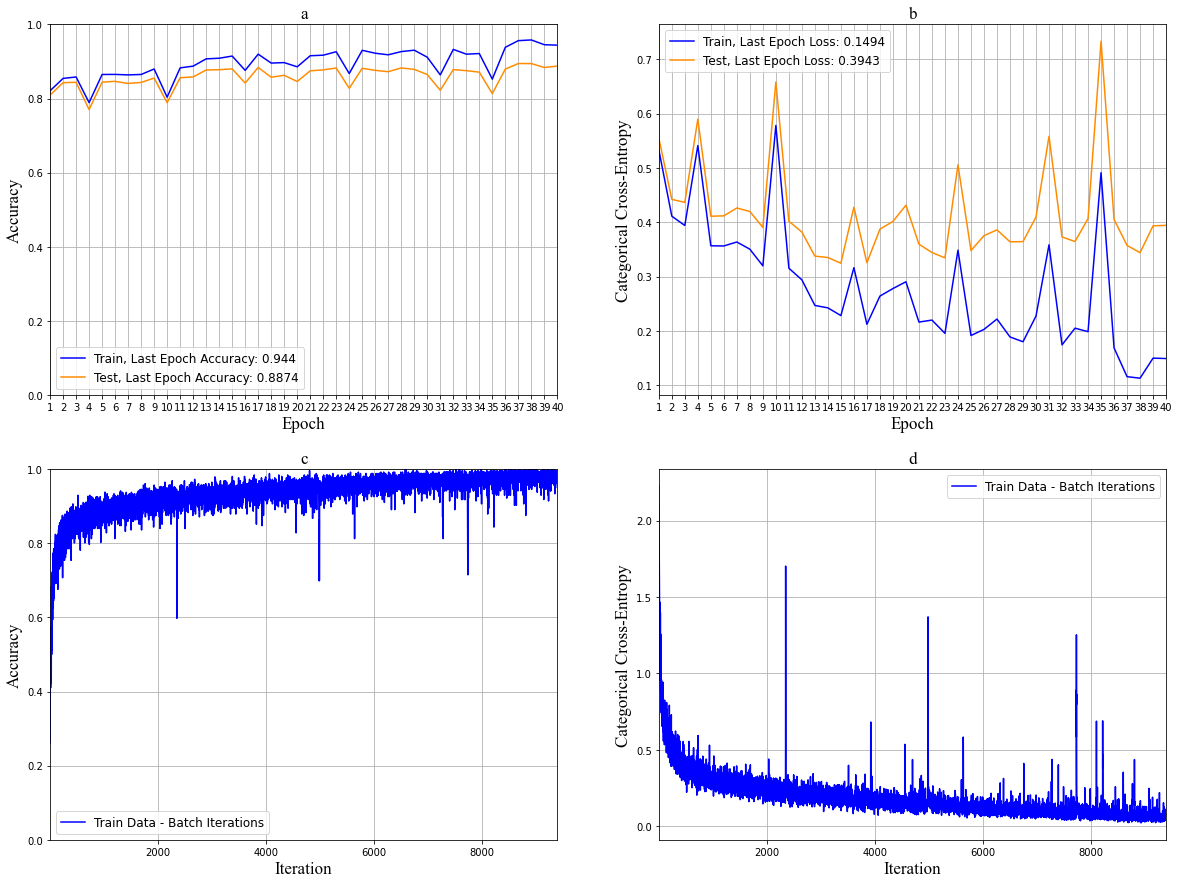

In [394]:
learning_rate = 1e-1
batch_size = 256
epochs = 40

epoch_accuracies = np.load('./npy_objects/epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
test_epoch_accuracies = np.load('npy_objects/test_epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
epoch_losses = np.load('npy_objects/epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
test_epoch_losses = np.load('npy_objects/test_epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
batch_accuracies = np.load('npy_objects/batch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
batch_losses = np.load('npy_objects/batch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)

from matplotlib.ticker import FormatStrFormatter
params = {'legend.fontsize': 12}
plt.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'

fig, axs = plt.subplots(2, 2, figsize=(20,15))
axs[0,0].plot(np.linspace(1, len(epoch_accuracies), len(epoch_accuracies)), epoch_accuracies, color='blue', label='Train, Last Epoch Accuracy: {}'.format(round(epoch_accuracies[-1], 4)))
axs[0,0].plot(np.linspace(1, len(test_epoch_accuracies), len(test_epoch_accuracies)), test_epoch_accuracies, color='darkorange', label='Test, Last Epoch Accuracy: {}'.format(round(test_epoch_accuracies[-1], 4)))
axs[0,0].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[0,0].set_ylabel('Accuracy', fontname='Times New Roman', fontsize=17)
axs[0,0].set_title('a', fontname='Times New Roman', fontsize=17)
axs[0,0].set_xlim(1, len(test_epoch_accuracies))
axs[0,0].set_xticks(np.linspace(1, len(epoch_accuracies), len(epoch_accuracies)))
axs[0,0].set_ylim(0, 1)
axs[0,0].grid()
axs[0,0].legend()

axs[0,1].plot(np.linspace(1, len(epoch_losses), len(epoch_losses)), epoch_losses, color='blue', label='Train, Last Epoch Loss: {}'.format(round(epoch_losses[-1], 4)))
axs[0,1].plot(np.linspace(1, len(test_epoch_losses), len(test_epoch_losses)), test_epoch_losses, color='darkorange', label='Test, Last Epoch Loss: {}'.format(round(test_epoch_losses[-1], 4)))
axs[0,1].set_title('b', fontname='Times New Roman', fontsize=17)
axs[0,1].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[0,1].set_ylabel('Categorical Cross-Entropy', fontname='Times New Roman', fontsize=17)
axs[0,1].set_xlim(1, len(test_epoch_losses))
axs[0,1].set_xticks(np.linspace(1, len(epoch_losses), len(epoch_losses)))
axs[0,1].grid()
axs[0,1].legend()

axs[1,0].plot(np.linspace(1, len(batch_accuracies), len(batch_accuracies)), batch_accuracies, color='blue', label='Train Data - Batch Iterations')
axs[1,0].set_title('c', fontname='Times New Roman', fontsize=17)
axs[1,0].set_xlabel('Iteration', fontname='Times New Roman', fontsize=17)
axs[1,0].set_ylabel('Accuracy', fontname='Times New Roman', fontsize=17)
axs[1,0].set_xlim(1, len(batch_accuracies))
axs[1,0].set_ylim(0, 1)
axs[1,0].grid()
axs[1,0].legend()

axs[1,1].plot(np.linspace(1, len(batch_losses), len(batch_losses)), batch_losses, color='blue', label='Train Data - Batch Iterations')
axs[1,1].set_title('d', fontname='Times New Roman', fontsize=17)
axs[1,1].set_xlabel('Iteration', fontname='Times New Roman', fontsize=17)
axs[1,1].set_ylabel('Categorical Cross-Entropy', fontname='Times New Roman', fontsize=17)
axs[1,1].set_xlim(1, len(batch_losses))
axs[1,1].grid()
axs[1,1].legend()

plt.show()

**Figure 5:** a) Accuracy of MLP as a function of epoch for train data (blue) and test data (orange). b) Categorical cross-entropy loss function value of MLP as a function of epoch for train data (blue) and test data (orange). c) Accuracy of MLP as a function of batch iteration for train data. d) Categorical cross-entropy loss function value of MLP as a function of batch iteration for train data. For all plots, the following hyper-parameters were used: $\text{epochs}=40$, $\text{batch-size}=256$, $\text{learning rate}=\eta=10^{-1}$.

In order to better assess the effect of the learning rate in terms of the convergence of the loss, we plot the categorical cross-entropy loss of the three models we ran above on the same plot, as shown in *Figure 6*.

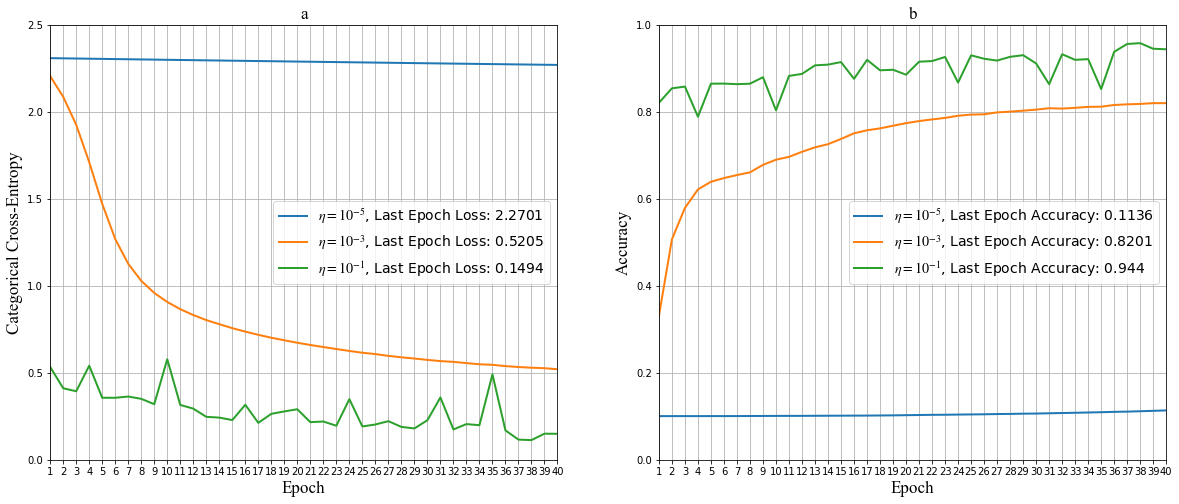

In [396]:
learning_rate = 1e-5
batch_size = 256

epochs = 40
epoch_losses_000001 = np.load('npy_objects/epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
epoch_accuracies_000001 = np.load('./npy_objects/epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)

learning_rate = 1e-3
epoch_losses_0001 = np.load('npy_objects/epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
epoch_accuracies_0001 = np.load('./npy_objects/epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)

learning_rate = 1e-1
epoch_losses_01 = np.load('npy_objects/epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
epoch_accuracies_01 = np.load('./npy_objects/epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)

from matplotlib.ticker import FormatStrFormatter
params = {'legend.fontsize': 14}
plt.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
fig, axs = plt.subplots(1, 2, figsize=(20,8))
axs[0].set_title('a', fontname='Times New Roman', fontsize=17)
axs[0].plot(np.linspace(1, len(epoch_losses_000001), len(epoch_losses_000001)), epoch_losses_000001, label=r'$\eta=10^{-5}$'+', Last Epoch Loss: {}'.format(round(epoch_losses_000001[-1], 4)), linewidth=2)
axs[0].plot(np.linspace(1, len(epoch_losses_0001), len(epoch_losses_0001)), epoch_losses_0001, label=r'$\eta=10^{-3}$'+', Last Epoch Loss: {}'.format(round(epoch_losses_0001[-1], 4)), linewidth=2)
axs[0].plot(np.linspace(1, len(epoch_losses_01), len(epoch_losses_01)), epoch_losses_01, label=r'$\eta=10^{-1}$'+', Last Epoch Loss: {}'.format(round(epoch_losses_01[-1], 4)), linewidth=2)
axs[0].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[0].set_ylabel('Categorical Cross-Entropy', fontname='Times New Roman', fontsize=17)
axs[0].set_xticks(np.linspace(1, len(epoch_losses_01), len(epoch_losses_01)))
axs[0].set_xlim(1, len(epoch_losses_01))
axs[0].set_ylim(0, 2.5)
axs[0].legend()
axs[0].grid()
axs[1].set_title('b', fontname='Times New Roman', fontsize=17)
axs[1].plot(np.linspace(1, len(epoch_accuracies_000001), len(epoch_accuracies_000001)), epoch_accuracies_000001, label=r'$\eta=10^{-5}$'+', Last Epoch Accuracy: {}'.format(round(epoch_accuracies_000001[-1], 4)), linewidth=2)
axs[1].plot(np.linspace(1, len(epoch_accuracies_0001), len(epoch_accuracies_0001)), epoch_accuracies_0001, label=r'$\eta=10^{-3}$'+', Last Epoch Accuracy: {}'.format(round(epoch_accuracies_0001[-1], 4)), linewidth=2)
axs[1].plot(np.linspace(1, len(epoch_accuracies_01), len(epoch_accuracies_01)), epoch_accuracies_01, label=r'$\eta=10^{-1}$'+', Last Epoch Accuracy: {}'.format(round(epoch_accuracies_01[-1], 4)), linewidth=2)
axs[1].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[1].set_ylabel('Accuracy', fontname='Times New Roman', fontsize=17)
axs[1].set_xticks(np.linspace(1, len(epoch_accuracies_01), len(epoch_accuracies_01)))
axs[1].set_xlim(1, len(epoch_accuracies_01))
axs[1].set_ylim(0, 1)
axs[1].legend()
axs[1].grid()
plt.show()

**Figure 6:** a) Categorical cross-entropy loss value of the train data plotted against epoch, b) Accuracy of the train data plotted against epoch, for $40$ epochs, batches-sizes of $256$ and learning-rates of $10^{-5}$ (blue), $10^{-3}$ (orange), and $10^{-1}$ (green).

We can see from *Figure 6* that the loss value from the train data decreases with increasing learning rate and that the accuracy increases with increasing learning rate. We also observe that a *small* learning rate results in a very slow decrease of the loss value, a *medium* learning rate results in a smooth decrease of the loss value that seems to converge with time, while a *large* learning rate does not converge; it *jumps*. This can be explained with the help of an illustration shown below in *Figure 7*, where for the purposes of visualisation, the loss value is depicted as convex in parameter-space of 1 parameter (in reality the parameter space is much more complex).

![title](./Images/losses.jpg)

**Figure 7:** Sketch of (simplified) convex loss function in single parameter-space, taking $6$ steps with three different learning rates from the same starting position a) *small* learning rate, b) *medium* learning rate, c) *large* learning rate.

*Figure 7* demonstrates that the learning rate heavily affects the speef of convergence. With a *small* learning rate, the decrease in loss value is more precise but very slow, while it is also possible that the model gets *stuck* in a local minimum of the loss function, hence the very slow increase in accuracy observed in *Figure 6*. On the other hand, using a *large* learning rate results in large jumps across the loss function which may miss the global minimum value, hence we observe divergent curves in *Figure 6*. Using a *medium* learning rate provides a good balance in order to efficiently and smoothly converge to the global minimum, and a hyper-parameter search would allow us to fine-tune it to the optimum value. In addition, a variable, epoch-dependent learning rate, i.e., learning rate annealing, would enable us to use a larger learning rate to broadly explore the loss function and decrease the learning rate in regions of low loss function values (and thus of high accuracy).

![title](./Images/learning_rate_error.jpg)

Citation: [1] Goodfellow, I., et. al., (2016), 'Deep Learning'

<a name="q113"></a>

#### Task 1.1.3 [^](#outline)

Finally, for this task, we train the MLP for $80$ epochs, using batches of $256$ data-points and a learning rate of $10^{-3}$.

In [18]:
# determining the hyper-parameters
learning_rate = 1e-3
batch_size = 256
epochs = 80

# determining the structure of the MLP network
mlp_config = (n_input, 400, 400, 400, 400, 400, n_classes)
mlp = MLP(mlp_config)
print(mlp)
mlp.train(x_train, y_train, x_test, y_test, learning_rate=learning_rate, batch_size=batch_size, epochs=epochs)
mlp.save_results(learning_rate=learning_rate, batch_size=batch_size, epochs=epochs)


MLP Characteristics:
--------------------
MLP Configuration: (784, 400, 400, 400, 400, 400, 10)
Weights shapes: [(400, 784), (400, 400), (400, 400), (400, 400), (400, 400), (10, 400)]             
Biases shapes: [(400,), (400,), (400,), (400,), (400,), (10,)]

Training Complete.



Next we plot the loss function value and the accuracy obtained from the MLP as a function of the number of epochs with the above set of hyper-parameters: $\text{epochs}=80$, $\text{batch-size}=256$, $\text{learning rate}=\eta=10^{-3}$, for both the training and the test data, as shown in *Figure 8*.

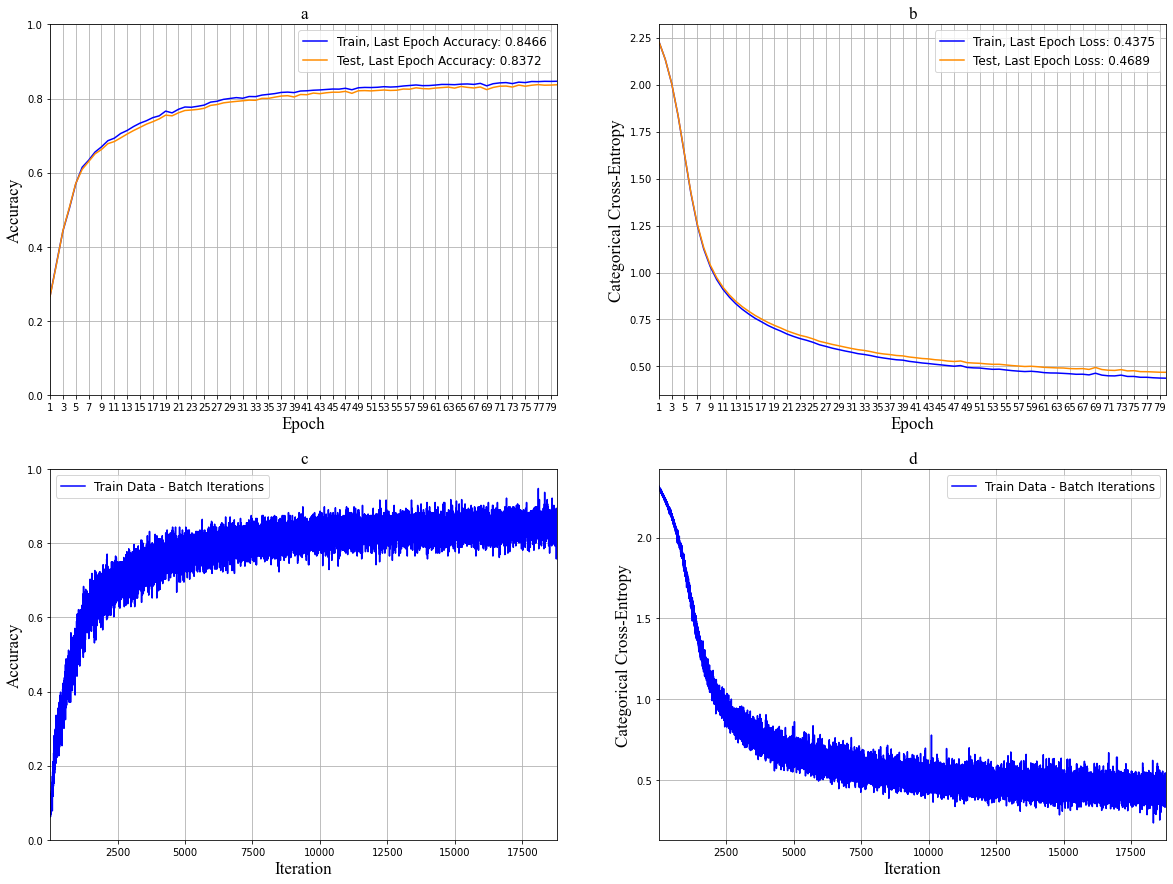

In [407]:
learning_rate = 1e-3
batch_size = 256
epochs = 80

epoch_accuracies = np.load('./npy_objects/epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
test_epoch_accuracies = np.load('npy_objects/test_epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
epoch_losses = np.load('npy_objects/epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
test_epoch_losses = np.load('npy_objects/test_epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
batch_accuracies = np.load('npy_objects/batch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
batch_losses = np.load('npy_objects/batch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)

from matplotlib.ticker import FormatStrFormatter
params = {'legend.fontsize': 12}
plt.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'

fig, axs = plt.subplots(2, 2, figsize=(20,15))
axs[0,0].plot(np.linspace(1, len(epoch_accuracies), len(epoch_accuracies)), epoch_accuracies, color='blue', label='Train, Last Epoch Accuracy: {}'.format(round(epoch_accuracies[-1], 4)))
axs[0,0].plot(np.linspace(1, len(test_epoch_accuracies), len(test_epoch_accuracies)), test_epoch_accuracies, color='darkorange', label='Test, Last Epoch Accuracy: {}'.format(round(test_epoch_accuracies[-1], 4)))
axs[0,0].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[0,0].set_ylabel('Accuracy', fontname='Times New Roman', fontsize=17)
axs[0,0].set_title('a', fontname='Times New Roman', fontsize=17)
axs[0,0].set_xlim(1, len(test_epoch_accuracies))
axs[0,0].set_xticks(np.arange(1, len(epoch_accuracies), 2))
axs[0,0].set_ylim(0, 1)
axs[0,0].grid()
axs[0,0].legend()

axs[0,1].plot(np.linspace(1, len(epoch_losses), len(epoch_losses)), epoch_losses, color='blue', label='Train, Last Epoch Loss: {}'.format(round(epoch_losses[-1], 4)))
axs[0,1].plot(np.linspace(1, len(test_epoch_losses), len(test_epoch_losses)), test_epoch_losses, color='darkorange', label='Test, Last Epoch Loss: {}'.format(round(test_epoch_losses[-1], 4)))
axs[0,1].set_title('b', fontname='Times New Roman', fontsize=17)
axs[0,1].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[0,1].set_ylabel('Categorical Cross-Entropy', fontname='Times New Roman', fontsize=17)
axs[0,1].set_xlim(1, len(test_epoch_losses))
axs[0,1].set_xticks(np.arange(1, len(epoch_losses), 2))
axs[0,1].grid()
axs[0,1].legend()

axs[1,0].plot(np.linspace(1, len(batch_accuracies), len(batch_accuracies)), batch_accuracies, color='blue', label='Train Data - Batch Iterations')
axs[1,0].set_title('c', fontname='Times New Roman', fontsize=17)
axs[1,0].set_xlabel('Iteration', fontname='Times New Roman', fontsize=17)
axs[1,0].set_ylabel('Accuracy', fontname='Times New Roman', fontsize=17)
axs[1,0].set_xlim(1, len(batch_accuracies))
axs[1,0].set_ylim(0, 1)
axs[1,0].grid()
axs[1,0].legend()

axs[1,1].plot(np.linspace(1, len(batch_losses), len(batch_losses)), batch_losses, color='blue', label='Train Data - Batch Iterations')
axs[1,1].set_title('d', fontname='Times New Roman', fontsize=17)
axs[1,1].set_xlabel('Iteration', fontname='Times New Roman', fontsize=17)
axs[1,1].set_ylabel('Categorical Cross-Entropy', fontname='Times New Roman', fontsize=17)
axs[1,1].set_xlim(1, len(batch_losses))
axs[1,1].grid()
axs[1,1].legend()

plt.show()

**Figure 8:** a) Accuracy of MLP as a function of epoch for train data (blue) and test data (orange). b) Categorical cross-entropy loss function value of MLP as a function of epoch for train data (blue) and test data (orange). c) Accuracy of MLP as a function of batch iteration for train data. d) Categorical cross-entropy loss function value of MLP as a function of batch iteration for train data. For all plots, the following hyper-parameters were used: $\text{epochs}=80$, $\text{batch-size}=256$, $\text{learning rate}=\eta=10^{-3}$.

To better compare the differences of increasing the number of epochs from $40$ to $80$ we plot the respective loss and accuracy of the train and test data, shown in *Figure 9* below.

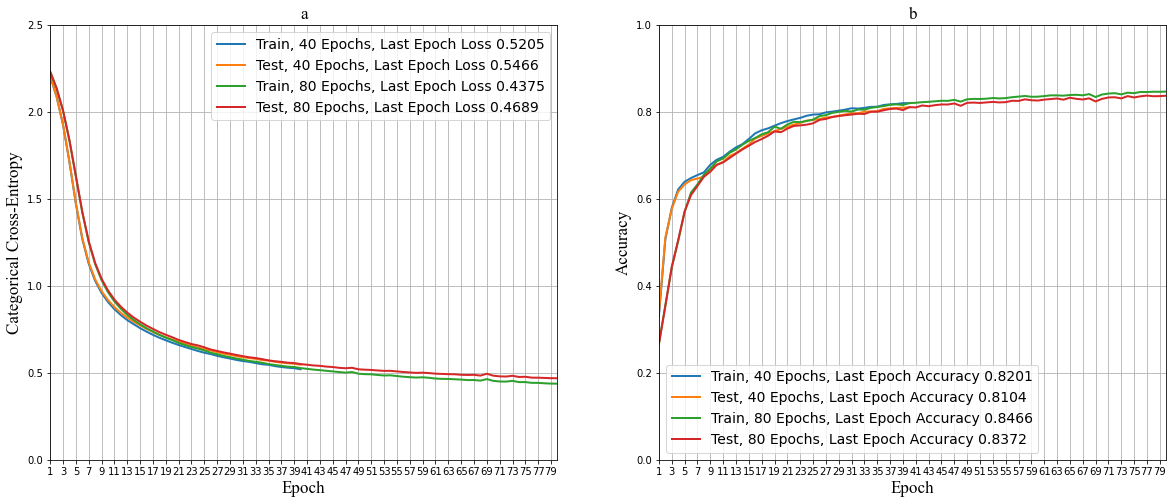

In [398]:
learning_rate = 1e-3
batch_size = 256
epochs = 40

epoch_losses_40 = np.load('npy_objects/epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
epoch_accuracies_40 = np.load('./npy_objects/epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
test_epoch_accuracies_40 = np.load('npy_objects/test_epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
test_epoch_losses_40 = np.load('npy_objects/test_epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)

epochs = 80
epoch_losses_80 = np.load('npy_objects/epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
epoch_accuracies_80 = np.load('./npy_objects/epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
test_epoch_accuracies_80 = np.load('npy_objects/test_epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
test_epoch_losses_80 = np.load('npy_objects/test_epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)


from matplotlib.ticker import FormatStrFormatter
params = {'legend.fontsize': 14}
plt.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
fig, axs = plt.subplots(1, 2, figsize=(20,8))
axs[0].set_title('a', fontname='Times New Roman', fontsize=17)
axs[0].plot(np.linspace(1, len(epoch_losses_40), len(epoch_losses_40)), epoch_losses_40, label='Train, 40 Epochs, Last Epoch Loss {}'.format(round(epoch_losses_40[-1], 4)), linewidth=2)
axs[0].plot(np.linspace(1, len(test_epoch_losses_40), len(test_epoch_losses_40)), test_epoch_losses_40, label='Test, 40 Epochs, Last Epoch Loss {}'.format(round(test_epoch_losses_40[-1], 4)), linewidth=2)
axs[0].plot(np.linspace(1, len(epoch_losses_80), len(epoch_losses_80)), epoch_losses_80, label='Train, 80 Epochs, Last Epoch Loss {}'.format(round(epoch_losses_80[-1], 4)), linewidth=2)
axs[0].plot(np.linspace(1, len(test_epoch_losses_80), len(test_epoch_losses_80)), test_epoch_losses_80, label='Test, 80 Epochs, Last Epoch Loss {}'.format(round(test_epoch_losses_80[-1], 4)), linewidth=2)
axs[0].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[0].set_ylabel('Categorical Cross-Entropy', fontname='Times New Roman', fontsize=17)
axs[0].set_xticks(np.arange(1, len(epoch_losses_80), 2))
axs[0].set_xlim(1, len(epoch_losses_80))
axs[0].set_ylim(0, 2.5)
axs[0].legend()
axs[0].grid()
axs[1].set_title('b', fontname='Times New Roman', fontsize=17)
axs[1].plot(np.linspace(1, len(epoch_accuracies_40), len(epoch_accuracies_40)), epoch_accuracies_40, label='Train, 40 Epochs, Last Epoch Accuracy {}'.format(round(epoch_accuracies_40[-1], 4)), linewidth=2)
axs[1].plot(np.linspace(1, len(test_epoch_accuracies_40), len(test_epoch_accuracies_40)), test_epoch_accuracies_40, label='Test, 40 Epochs, Last Epoch Accuracy {}'.format(round(test_epoch_accuracies_40[-1], 4)), linewidth=2)
axs[1].plot(np.linspace(1, len(epoch_accuracies_80), len(epoch_accuracies_80)), epoch_accuracies_80, label='Train, 80 Epochs, Last Epoch Accuracy {}'.format(round(epoch_accuracies_80[-1], 4)), linewidth=2)
axs[1].plot(np.linspace(1, len(test_epoch_accuracies_80), len(test_epoch_accuracies_80)), test_epoch_accuracies_80, label='Test, 80 Epochs, Last Epoch Accuracy {}'.format(round(test_epoch_accuracies_80[-1], 4)), linewidth=2)
axs[1].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[1].set_ylabel('Accuracy', fontname='Times New Roman', fontsize=17)
axs[1].set_xticks(np.arange(1, len(epoch_accuracies_80), 2))
axs[1].set_xlim(1, len(epoch_accuracies_80))
axs[1].set_ylim(0, 1)
axs[1].legend()
axs[1].grid()
plt.show()

**Figure 9:** a) Categorical cross-entropy loss value of the train and test data plotted against epoch, b) Accuracy of the train and test data plotted against epoch, for batch-sizes of $256$, learning-rate of $10^{-3}$, and of $40$ and $80$ epochs.

We can see from *Figure 9* that the two models learned on $40$ and $80$ epochs superimpose each other on average, as is expected, since they use the same hyper-parameters: batch size and learning rate. Small deviations are expected and arise from the random initialisation of the weights and the random set of points chosen in each batch. However, we can also observe that the gap in loss value between the train and test data is higher at the end of the $80$ epochs than at the end of the $40$ epochs. This demonstrates that with increasing epochs the model begins to over-fit and begins to 'memorise' rather than learn the data, hence, the in-sample (train data) loss decreases faster than the out-of-sample (test data) loss.

Generalisation error is very small (difference between train and test accuracy/loss) -> it hasn't overfitted. Very small increase in that error with increasing epoch.

Overall it seems to have converged.

It does up to a point (convergence) and then it has minimal effect (use early stopping).

<a name="q12"></a>
## 1.2 Convolutional Neural Network (CNN) [^](#outline)

<a name="q121"></a>

#### Task 1.2.1 [^](#outline)

In [16]:
def load_data():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)  # convert labels to categorical samples
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
    return (x_train, y_train, x_test, y_test)


x_train, y_train, x_test, y_test = load_data()  # import the data

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LeakyReLU
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import categorical_crossentropy


def get_model():
    model = Sequential([
        # Input layer is implicit in 1st convolutional layer
        Conv2D(8, (3, 3), activation=LeakyReLU(alpha=0.01), input_shape=(28, 28, 1)),  # First convolutional layer, input: 28x28 image with 1 channel, 8 feature maps, 3x3 filters
        Conv2D(8, (3, 3), activation=LeakyReLU(alpha=0.01)),  # 2nd convolutional layer, 8 feature maps, 3x3 filters
        Conv2D(16, (3, 3), activation=LeakyReLU(alpha=0.01)),  # 3rd convolutional layer, 16 feature maps, 3x3 filters
        Conv2D(16, (3, 3), activation=LeakyReLU(alpha=0.01)),  # 4th convolutional layer, 16 feature maps, 3x3 filters
        MaxPooling2D((2, 2)),  # 2x2 max-pooling layer
        Flatten(),  # Flattens 2D max-pooling layer to connect to fully-conected layer
        Dense(64, activation=LeakyReLU(alpha=0.01)),  # fully-connecte (dense) layer
        Dense(10, activation='softmax')  # output layer with softmax activation function
    ])
    # model uses categorical cross-entorpy as loss function, using Stochastic Gradient Descent (SGD), with a learning rate of 10^-3 and accuracy as its metric
    model.compile(loss=categorical_crossentropy, optimizer=SGD(learning_rate=1e-3), metrics=['accuracy'])
    return model

In [18]:
cnn = get_model()  # obtain the model
cnn_layer_names = [layer.name for layer in cnn.layers]  # obtain the names of all layers to use later in visualisations
print(cnn.summary())  # obtain model summary

2022-03-23 14:01:42.943153: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-23 14:01:42.943248: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (georgealevras-XPS-15-9570): /proc/driver/nvidia/version does not exist
2022-03-23 14:01:42.944830: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 8)         80        
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 8)         584       
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 16)        1168      
                                                                 
 conv2d_3 (Conv2D)           (None, 20, 20, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                        

In [19]:
# combine the x_train and y_train data in a single train_data object
train_data = tf.data.Dataset.from_tensor_slices((x_train.astype(np.float32), y_train.astype(np.float32)))
train_data = train_data.shuffle(1024)  # shuffles data to randomise order of images
train_data = train_data.batch(256)  # splits training data in batches of size 256

# combine the x_test and y_test data in a single train_data object
test_data = tf.data.Dataset.from_tensor_slices((x_test.astype(np.float32), y_test.astype(np.float32)))
test_data = test_data.batch(256)

In [32]:
history = cnn.fit(train_data, validation_data=test_data, epochs=40, verbose=0)

cnn_1_2_1_train_loss = history.history['loss']
cnn_1_2_1_train_acc = history.history['accuracy']
cnn_1_2_1_test_loss = history.history['val_loss']
cnn_1_2_1_test_acc = history.history['val_accuracy']
np.save(os.path.join('npy_objects', 'cnn_1_2_1_train_loss'), np.array(cnn_1_2_1_train_loss))
np.save(os.path.join('npy_objects', 'cnn_1_2_1_train_acc'), np.array(cnn_1_2_1_train_acc))
np.save(os.path.join('npy_objects', 'cnn_1_2_1_test_loss'), np.array(cnn_1_2_1_test_loss))
np.save(os.path.join('npy_objects', 'cnn_1_2_1_test_acc'), np.array(cnn_1_2_1_test_acc))

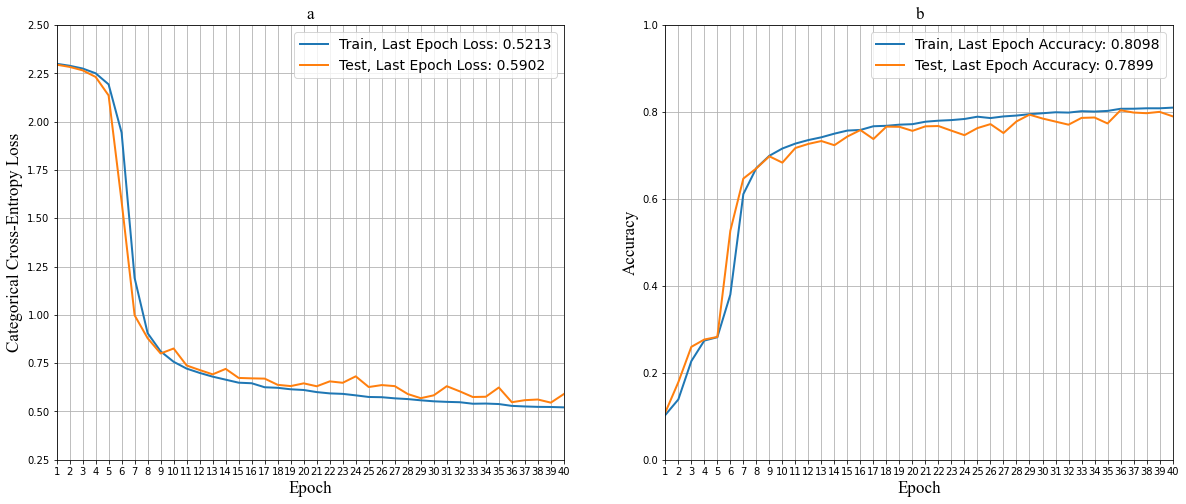

In [409]:
cnn_1_2_1_train_loss = np.load('npy_objects/cnn_1_2_1_train_loss.npy', allow_pickle=True)
cnn_1_2_1_train_acc = np.load('npy_objects/cnn_1_2_1_train_acc.npy', allow_pickle=True)
cnn_1_2_1_test_loss = np.load('npy_objects/cnn_1_2_1_test_loss.npy', allow_pickle=True)
cnn_1_2_1_test_acc = np.load('npy_objects/cnn_1_2_1_test_acc.npy', allow_pickle=True)


from matplotlib.ticker import FormatStrFormatter
params = {'legend.fontsize': 14}
plt.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
fig, axs = plt.subplots(1, 2, figsize=(20,8))
axs[0].set_title('a', fontname='Times New Roman', fontsize=17)
axs[0].plot(np.linspace(1, len(cnn_1_2_1_train_loss), len(cnn_1_2_1_train_loss)), cnn_1_2_1_train_loss, label='Train, Last Epoch Loss: {}'.format(round(cnn_1_2_1_train_loss[-1], 4)), linewidth=2)
axs[0].plot(np.linspace(1, len(cnn_1_2_1_test_loss), len(cnn_1_2_1_test_loss)), cnn_1_2_1_test_loss, label='Test, Last Epoch Loss: {}'.format(round(cnn_1_2_1_test_loss[-1], 4)), linewidth=2)
axs[0].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[0].set_ylabel('Categorical Cross-Entropy Loss', fontname='Times New Roman', fontsize=17)
axs[0].set_xticks(np.linspace(1, len(cnn_1_2_1_train_loss), len(cnn_1_2_1_train_loss)))
axs[0].set_xlim(1, len(cnn_1_2_1_train_loss))
axs[0].set_ylim(0.25, 2.5)
axs[0].legend()
axs[0].grid()
axs[1].set_title('b', fontname='Times New Roman', fontsize=17)
axs[1].plot(np.linspace(1, len(cnn_1_2_1_train_acc), len(cnn_1_2_1_train_acc)), cnn_1_2_1_train_acc, label='Train, Last Epoch Accuracy: {}'.format(round(cnn_1_2_1_train_acc[-1], 4)), linewidth=2)
axs[1].plot(np.linspace(1, len(cnn_1_2_1_train_acc), len(cnn_1_2_1_train_acc)), cnn_1_2_1_test_acc, label='Test, Last Epoch Accuracy: {}'.format(round(cnn_1_2_1_test_acc[-1], 4)), linewidth=2)
axs[1].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[1].set_ylabel('Accuracy', fontname='Times New Roman', fontsize=17)
axs[1].set_xticks(np.linspace(1, len(cnn_1_2_1_train_acc), len(cnn_1_2_1_train_acc)))
axs[1].set_xlim(1, len(cnn_1_2_1_train_acc))
axs[1].set_ylim(0, 1)
axs[1].legend()
axs[1].grid()
plt.show()

<a name="q122"></a>

#### Task 1.2.2 [^](#outline)

In [21]:
from tensorflow.keras.layers import Dropout

def get_model_dropout(rate):
    model = Sequential([
        Conv2D(8, (3, 3), activation=LeakyReLU(alpha=0.01), input_shape=(28, 28, 1)),
        Conv2D(8, (3, 3), activation=LeakyReLU(alpha=0.01)),
        Conv2D(16, (3, 3), activation=LeakyReLU(alpha=0.01)),
        Conv2D(16, (3, 3), activation=LeakyReLU(alpha=0.01)),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation=LeakyReLU(alpha=0.01)),
        Dropout(rate),
        Dense(10, activation='softmax')
    ])
    model.compile(loss=categorical_crossentropy, optimizer=SGD(learning_rate=1e-3), metrics=['accuracy'])
    return model


In [105]:
split_rate = 0.8
x_train_split, x_val_split = np.split(x_train, [int(split_rate*(x_train.shape[0]))])
y_train_split, y_val_split = np.split(y_train, [int(split_rate*(y_train.shape[0]))])

train_data_122 = tf.data.Dataset.from_tensor_slices((x_train_split.astype(np.float32), y_train_split.astype(np.float32)))
train_data_122 = train_data_122.shuffle(1024)
train_data_122 = train_data_122.batch(256)

val_data_122 = tf.data.Dataset.from_tensor_slices((x_val_split.astype(np.float32), y_val_split.astype(np.float32)))
val_data_122 = val_data_122.batch(256)

train_losses_122 = []
train_accs_122 = []
val_losses_122 = []
val_accs_122 = []
for d in np.linspace(0.1, 0.9, 9):
    cnn_dropout = get_model_dropout(d)
    history_dropout = cnn_dropout.fit(train_data_122, validation_data=val_data_122, epochs=40, verbose=0)
    
    train_losses_122.append(history_dropout.history['loss'])
    train_accs_122.append(history_dropout.history['accuracy'])
    val_losses_122.append(history_dropout.history['val_loss'])
    val_accs_122.append(history_dropout.history['val_accuracy'])
    
    print('Checking dropout rate d={}'.format(round(d, 1)))
    
np.save(os.path.join('npy_objects', 'train_losses_122'), np.array(train_losses_122))
np.save(os.path.join('npy_objects', 'train_accs_122'), np.array(train_accs_122))
np.save(os.path.join('npy_objects', 'val_losses_122'), np.array(val_losses_122))
np.save(os.path.join('npy_objects', 'val_accs_122'), np.array(val_accs_122))

Checking dropout rate d=0.1
Checking dropout rate d=0.2
Checking dropout rate d=0.3
Checking dropout rate d=0.4
Checking dropout rate d=0.5
Checking dropout rate d=0.6
Checking dropout rate d=0.7
Checking dropout rate d=0.8
Checking dropout rate d=0.9


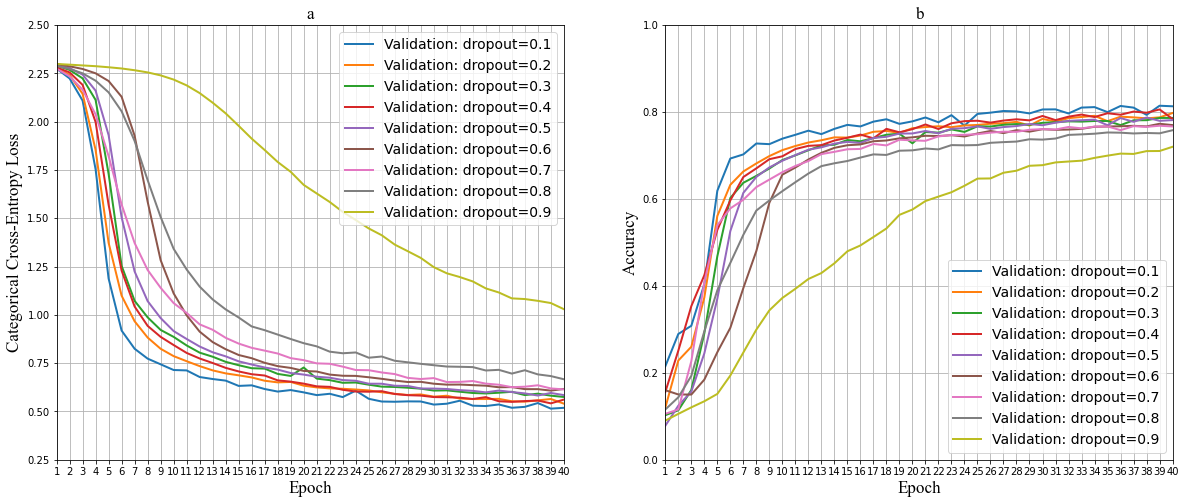

In [410]:
train_losses_122 = np.load('npy_objects/train_losses_122.npy', allow_pickle=True)
train_accs_122 = np.load('npy_objects/train_accs_122.npy', allow_pickle=True)
val_losses_122 = np.load('npy_objects/val_losses_122.npy', allow_pickle=True)
val_accs_122 = np.load('npy_objects/val_accs_122.npy', allow_pickle=True)


from matplotlib.ticker import FormatStrFormatter
params = {'legend.fontsize': 14}
plt.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
fig, axs = plt.subplots(1, 2, figsize=(20,8))
axs[0].set_title('a', fontname='Times New Roman', fontsize=17)
for i in range(len(val_losses_122)):
    axs[0].plot(np.linspace(1, len(val_losses_122[i]), len(val_losses_122[i])), val_losses_122[i], label='Validation: dropout={}'.format(round(0.1+i*0.1, 1)), linewidth=2)
axs[0].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[0].set_ylabel('Categorical Cross-Entropy Loss', fontname='Times New Roman', fontsize=17)
axs[0].set_xticks(np.linspace(1, len(val_losses_122[0]), len(val_losses_122[0])))
axs[0].set_xlim(1, len(val_losses_122[i]))
axs[0].set_ylim(0.25, 2.5)
axs[0].legend()
axs[0].grid()
axs[1].set_title('b', fontname='Times New Roman', fontsize=17)
for i in range(len(val_accs_122)):
    axs[1].plot(np.linspace(1, len(val_accs_122[i]), len(val_accs_122[i])), val_accs_122[i], label='Validation: dropout={}'.format(round(0.1+i*0.1, 1)), linewidth=2)
axs[1].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[1].set_ylabel('Accuracy', fontname='Times New Roman', fontsize=17)
axs[1].set_xticks(np.linspace(1, len(val_accs_122[0]), len(val_accs_122[0])))
axs[1].set_xlim(1, len(val_accs_122[i]))
axs[1].set_ylim(0, 1)
axs[1].legend()
axs[1].grid()
plt.show()

In [23]:
val_accs_with_dropout_last = [val_accs_122[i][-1] for i in range(len(val_accs_122))]

dropouts = np.linspace(0.1, 0.9, 9)

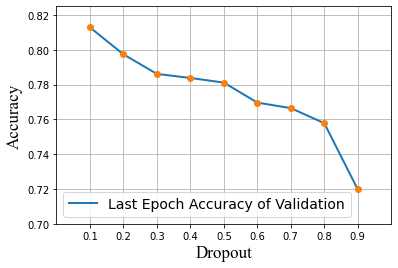

In [401]:
from matplotlib.ticker import FormatStrFormatter
params = {'legend.fontsize': 14}
plt.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'

plt.plot(dropouts, val_accs_with_dropout_last, label='Last Epoch Accuracy of Validation', linewidth=2)
plt.plot(dropouts, val_accs_with_dropout_last, 'o')
plt.xlabel('Dropout', fontname='Times New Roman', fontsize=17)
plt.ylabel('Accuracy', fontname='Times New Roman', fontsize=17)
plt.xticks(dropouts)
plt.xlim(0, 1)
plt.ylim(0.7, 0.825)
plt.legend()
plt.grid()
plt.show()

In [25]:
optimum_dropout = dropouts[np.argmax(val_accs_with_dropout_last)]

In [26]:
cnn_optimum_dropout = get_model_dropout(optimum_dropout)
cnn_optimum_layer_names = [layer.name for layer in cnn_optimum_dropout.layers]
print(cnn_optimum_dropout.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 8)         80        
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 8)         584       
                                                                 
 conv2d_6 (Conv2D)           (None, 22, 22, 16)        1168      
                                                                 
 conv2d_7 (Conv2D)           (None, 20, 20, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 16)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                      

In [34]:
history_optimum_dropout = cnn_optimum_dropout.fit(train_data, validation_data=test_data, epochs=40, verbose=0)
cnn_1_2_2_train_loss = history_optimum_dropout.history['loss']
cnn_1_2_2_train_acc = history_optimum_dropout.history['accuracy']
cnn_1_2_2_test_loss = history_optimum_dropout.history['val_loss']
cnn_1_2_2_test_acc = history_optimum_dropout.history['val_accuracy']
np.save(os.path.join('npy_objects', 'cnn_1_2_2_train_loss'), np.array(cnn_1_2_2_train_loss))
np.save(os.path.join('npy_objects', 'cnn_1_2_2_train_acc'), np.array(cnn_1_2_2_train_acc))
np.save(os.path.join('npy_objects', 'cnn_1_2_2_test_loss'), np.array(cnn_1_2_2_test_loss))
np.save(os.path.join('npy_objects', 'cnn_1_2_2_test_acc'), np.array(cnn_1_2_2_test_acc))

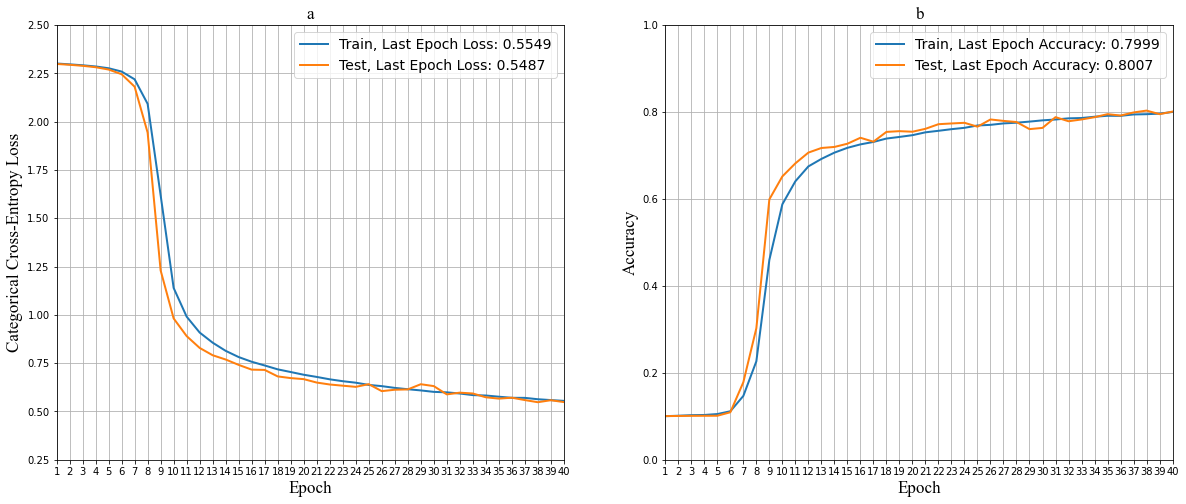

In [411]:
cnn_1_2_2_train_loss = np.load('npy_objects/cnn_1_2_2_train_loss.npy', allow_pickle=True)
cnn_1_2_2_train_acc = np.load('npy_objects/cnn_1_2_2_train_acc.npy', allow_pickle=True)
cnn_1_2_2_test_loss = np.load('npy_objects/cnn_1_2_2_test_loss.npy', allow_pickle=True)
cnn_1_2_2_test_acc = np.load('npy_objects/cnn_1_2_2_test_acc.npy', allow_pickle=True)


from matplotlib.ticker import FormatStrFormatter
params = {'legend.fontsize': 14}
plt.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
fig, axs = plt.subplots(1, 2, figsize=(20,8))
axs[0].set_title('a', fontname='Times New Roman', fontsize=17)
axs[0].plot(np.linspace(1, len(cnn_1_2_2_train_loss), len(cnn_1_2_2_train_loss)), cnn_1_2_2_train_loss, label='Train, Last Epoch Loss: {}'.format(round(cnn_1_2_2_train_loss[-1], 4)), linewidth=2)
axs[0].plot(np.linspace(1, len(cnn_1_2_2_test_loss), len(cnn_1_2_2_test_loss)), cnn_1_2_2_test_loss, label='Test, Last Epoch Loss: {}'.format(round(cnn_1_2_2_test_loss[-1], 4)), linewidth=2)
axs[0].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[0].set_ylabel('Categorical Cross-Entropy Loss', fontname='Times New Roman', fontsize=17)
axs[0].set_xticks(np.linspace(1, len(cnn_1_2_2_train_loss), len(cnn_1_2_2_train_loss)))
axs[0].set_xlim(1, len(cnn_1_2_2_train_loss))
axs[0].set_ylim(0.25, 2.5)
axs[0].legend()
axs[0].grid()
axs[1].set_title('b', fontname='Times New Roman', fontsize=17)
axs[1].plot(np.linspace(1, len(cnn_1_2_2_train_acc), len(cnn_1_2_2_train_acc)), cnn_1_2_2_train_acc, label='Train, Last Epoch Accuracy: {}'.format(round(cnn_1_2_2_train_acc[-1], 4)), linewidth=2)
axs[1].plot(np.linspace(1, len(cnn_1_2_2_train_acc), len(cnn_1_2_2_train_acc)), cnn_1_2_2_test_acc, label='Test, Last Epoch Accuracy: {}'.format(round(cnn_1_2_2_test_acc[-1], 4)), linewidth=2)
axs[1].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[1].set_ylabel('Accuracy', fontname='Times New Roman', fontsize=17)
axs[1].set_xticks(np.linspace(1, len(cnn_1_2_2_train_acc), len(cnn_1_2_2_train_acc)))
axs[1].set_xlim(1, len(cnn_1_2_2_train_acc))
axs[1].set_ylim(0, 1)
axs[1].legend()
axs[1].grid()
plt.show()

In [36]:
from tensorflow.keras.models import Model

inputs = cnn.inputs
layer_names = [cnn_layer_names[6]]
outputs = [cnn.get_layer(layer_name).output for layer_name in layer_names]
cnn_features = Model(inputs=inputs, outputs=outputs)
features_cnn = cnn_features.predict(x_test)
np.save(os.path.join('npy_objects', 'features_cnn'), np.array(features_cnn))

inputs_optimum_dropout = cnn_optimum_dropout.inputs
layer_names_optimum_dropout = [cnn_optimum_layer_names[6]]
outputs_optimum_dropout = [cnn_optimum_dropout.get_layer(layer_name).output for layer_name in layer_names_optimum_dropout]
cnn_features_optimum_dropout = Model(inputs=inputs_optimum_dropout, outputs=outputs_optimum_dropout)
features_optimum_dropout = cnn_features_optimum_dropout.predict(x_test)
np.save(os.path.join('npy_objects', 'features_optimum_dropout'), np.array(features_optimum_dropout))

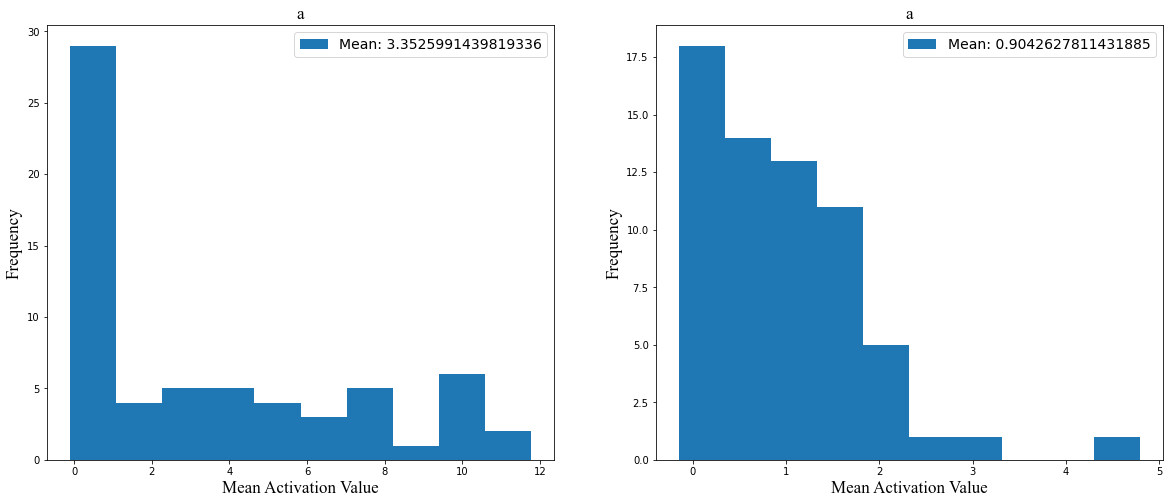

In [37]:
features_cnn = np.load('npy_objects/features_cnn.npy', allow_pickle=True)
features_optimum_dropout = np.load('npy_objects/features_optimum_dropout.npy', allow_pickle=True)

fig, axs = plt.subplots(1, 2, figsize=(20,8))
axs[0].set_title('a', fontname='Times New Roman', fontsize=17)
axs[0].hist(np.mean(features_cnn, axis=0), label='Mean: {}'.format(np.mean(np.mean(features_cnn, axis=0))))
axs[0].set_xlabel('Mean Activation Value', fontname='Times New Roman', fontsize=17)
axs[0].set_ylabel('Frequency', fontname='Times New Roman', fontsize=17)
axs[0].legend()
axs[1].set_title('a', fontname='Times New Roman', fontsize=17)
axs[1].hist(np.mean(features_optimum_dropout, axis=0), label='Mean: {}'.format(np.mean(np.mean(features_optimum_dropout, axis=0))))
axs[1].set_xlabel('Mean Activation Value', fontname='Times New Roman', fontsize=17)
axs[1].set_ylabel('Frequency', fontname='Times New Roman', fontsize=17)
axs[1].legend()
plt.show()

<a name="q123"></a>

#### Task 1.2.3 [^](#outline)

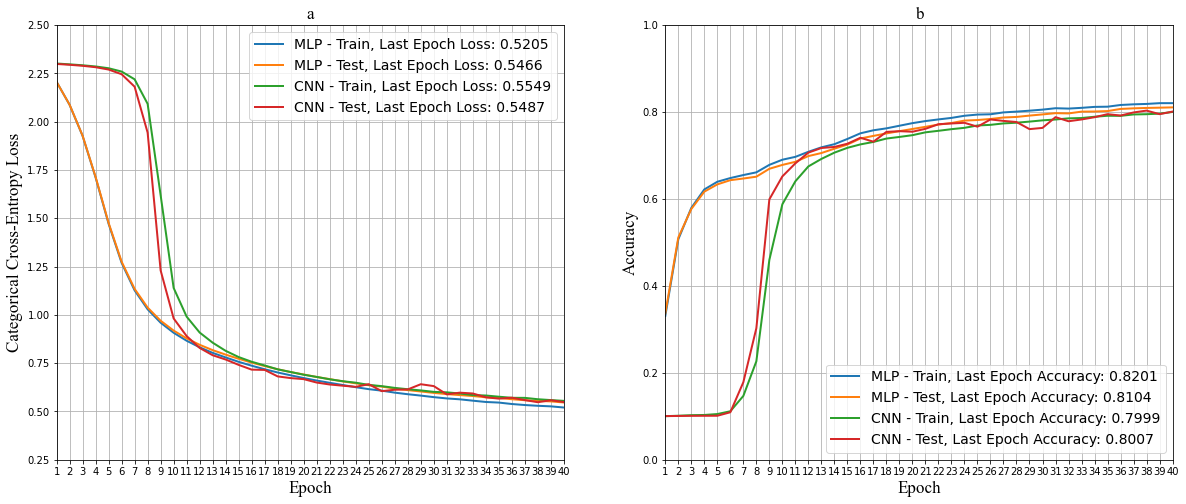

In [412]:
cnn_1_2_2_train_loss = np.load('npy_objects/cnn_1_2_2_train_loss.npy', allow_pickle=True)
cnn_1_2_2_train_acc = np.load('npy_objects/cnn_1_2_2_train_acc.npy', allow_pickle=True)
cnn_1_2_2_test_loss = np.load('npy_objects/cnn_1_2_2_test_loss.npy', allow_pickle=True)
cnn_1_2_2_test_acc = np.load('npy_objects/cnn_1_2_2_test_acc.npy', allow_pickle=True)
learning_rate = 1e-3
batch_size = 256
epochs = 40

epoch_accuracies = np.load('./npy_objects/epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
test_epoch_accuracies = np.load('npy_objects/test_epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
epoch_losses = np.load('npy_objects/epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
test_epoch_losses = np.load('npy_objects/test_epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)


from matplotlib.ticker import FormatStrFormatter
params = {'legend.fontsize': 14}
plt.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
fig, axs = plt.subplots(1, 2, figsize=(20,8))
axs[0].set_title('a', fontname='Times New Roman', fontsize=17)
axs[0].plot(np.linspace(1, len(epoch_losses), len(epoch_losses)), epoch_losses, label='MLP - Train, Last Epoch Loss: {}'.format(round(epoch_losses[-1], 4)), linewidth=2)
axs[0].plot(np.linspace(1, len(test_epoch_losses), len(test_epoch_losses)), test_epoch_losses, label='MLP - Test, Last Epoch Loss: {}'.format(round(test_epoch_losses[-1], 4)), linewidth=2)
axs[0].plot(np.linspace(1, len(cnn_1_2_2_train_loss), len(cnn_1_2_2_train_loss)), cnn_1_2_2_train_loss, label='CNN - Train, Last Epoch Loss: {}'.format(round(cnn_1_2_2_train_loss[-1], 4)), linewidth=2)
axs[0].plot(np.linspace(1, len(cnn_1_2_2_test_loss), len(cnn_1_2_2_test_loss)), cnn_1_2_2_test_loss, label='CNN - Test, Last Epoch Loss: {}'.format(round(cnn_1_2_2_test_loss[-1], 4)), linewidth=2)
axs[0].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[0].set_ylabel('Categorical Cross-Entropy Loss', fontname='Times New Roman', fontsize=17)
axs[0].set_xticks(np.linspace(1, len(epoch_losses), len(epoch_losses)))
axs[0].set_xlim(1, len(cnn_1_2_2_train_loss))
axs[0].set_ylim(0.25, 2.5)
axs[0].legend()
axs[0].grid()
axs[1].set_title('b', fontname='Times New Roman', fontsize=17)
axs[1].plot(np.linspace(1, len(epoch_accuracies), len(epoch_accuracies)), epoch_accuracies, label='MLP - Train, Last Epoch Accuracy: {}'.format(round(epoch_accuracies[-1], 4)), linewidth=2)
axs[1].plot(np.linspace(1, len(test_epoch_accuracies), len(test_epoch_accuracies)), test_epoch_accuracies, label='MLP - Test, Last Epoch Accuracy: {}'.format(round(test_epoch_accuracies[-1], 4)), linewidth=2)
axs[1].plot(np.linspace(1, len(cnn_1_2_2_train_acc), len(cnn_1_2_2_train_acc)), cnn_1_2_2_train_acc, label='CNN - Train, Last Epoch Accuracy: {}'.format(round(cnn_1_2_2_train_acc[-1], 4)), linewidth=2)
axs[1].plot(np.linspace(1, len(cnn_1_2_2_train_acc), len(cnn_1_2_2_train_acc)), cnn_1_2_2_test_acc, label='CNN - Test, Last Epoch Accuracy: {}'.format(round(cnn_1_2_2_test_acc[-1], 4)), linewidth=2)
axs[1].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[1].set_ylabel('Accuracy', fontname='Times New Roman', fontsize=17)
axs[1].set_xticks(np.linspace(1, len(epoch_accuracies), len(epoch_accuracies)))
axs[1].set_xlim(1, len(cnn_1_2_2_train_acc))
axs[1].set_ylim(0, 1)
axs[1].legend()
axs[1].grid()
plt.show()

<a name="q124"></a>

#### Task 1.2.4 [^](#outline)

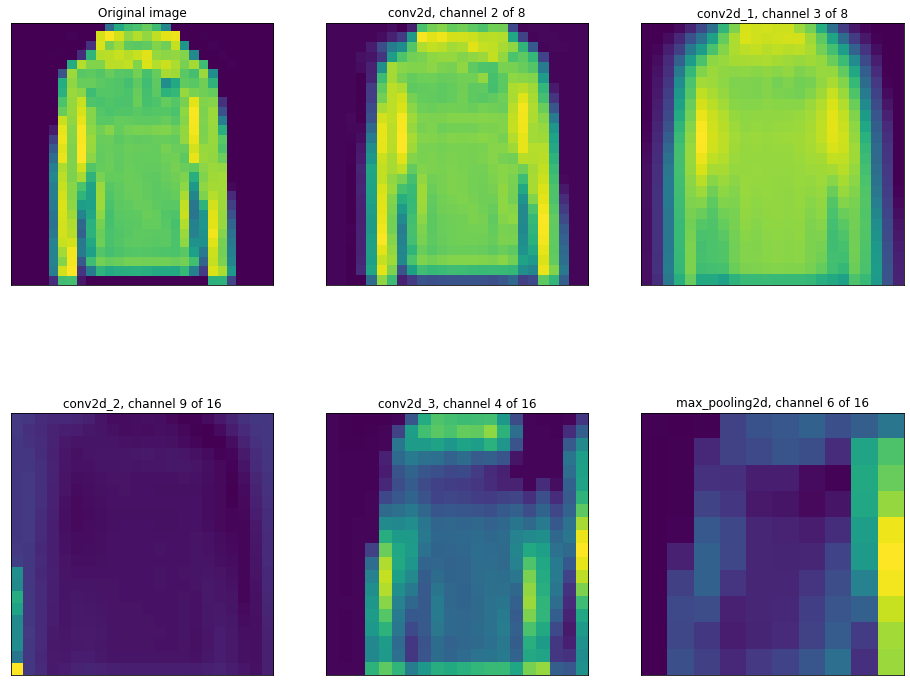

In [39]:
image = x_train[24][tf.newaxis,...]

inputs = cnn.inputs
layer_names = cnn_layer_names[:5]
outputs = [cnn.get_layer(layer_name).output for layer_name in layer_names]
cnn_features = Model(inputs=inputs, outputs=outputs)
features_cnn = cnn_features.predict(image)

n_rows, n_cols = 2, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 14))
fig.subplots_adjust(hspace=0.05, wspace=0.2)

for i in range(len(features_cnn)+1):
    feature_map = features_cnn[i-1]
    num_channels = feature_map.shape[-1]
    row = i // n_cols
    col = i % n_cols
    if i == 0:
        axes[row, col].imshow(image[0])
        axes[row, col].set_title('Original image')
    else:
        random_feature = np.random.choice(num_channels)
        axes[row, col].imshow(feature_map[0, ..., random_feature])
        axes[row, col].set_title('{}, channel {} of {}'.format(layer_names[i-1], random_feature + 1, num_channels))
        
    axes[row, col].get_xaxis().set_visible(False)
    axes[row, col].get_yaxis().set_visible(False)
plt.show()

<a name="task-2"></a>

# Task 2: Unsupervised Learning [^](#outline)

<a name="q21"></a>

## 2.1 Dimensionality Reduction and Clustering of a Subset of the Fashion-MNIST Image Data [^](#outline)

<a name="q211"></a>

#### Task 2.1.1 [^](#outline)

In [106]:
pca_images = x_train.copy()[:1000]

In [107]:
X = (pca_images.reshape(-1, 28 * 28)[:pca_images.shape[0]])

In [108]:
def standardise(X):
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xbar = ((X-mu)/std_filled)
    return Xbar

In [109]:
X = standardise(X)

In [116]:
from scipy.sparse import linalg

def pca_function(X, m):

    # create covariance matrix S
    C = 1.0/(len(X)-1) * np.dot(X.T, X)


    # compute eigenvalues and eigenvectors using the eigsh scipy function
    eigenvalues, eigenvectors = linalg.eigsh(C, m, which="LM", return_eigenvectors=True) 

    # sorting the eigenvectors and eigenvalues from largest to smallest eigenvalue
    sorted_index = np.argsort(eigenvalues)[::-1]
    eigenvalues=eigenvalues[sorted_index]
    eigenvectors=eigenvectors[:,sorted_index ]

    # transform our data
    X_pca = X.dot(eigenvectors)

    return X_pca, eigenvectors, eigenvalues

In [170]:
m = 25

# compute the projection, the eigenvector and eigenvalues from our function
X_pca, eigenvectors, eigenvalues = pca_function(X, m)

<a name="q212"></a>

#### Task 2.1.2 [^](#outline)

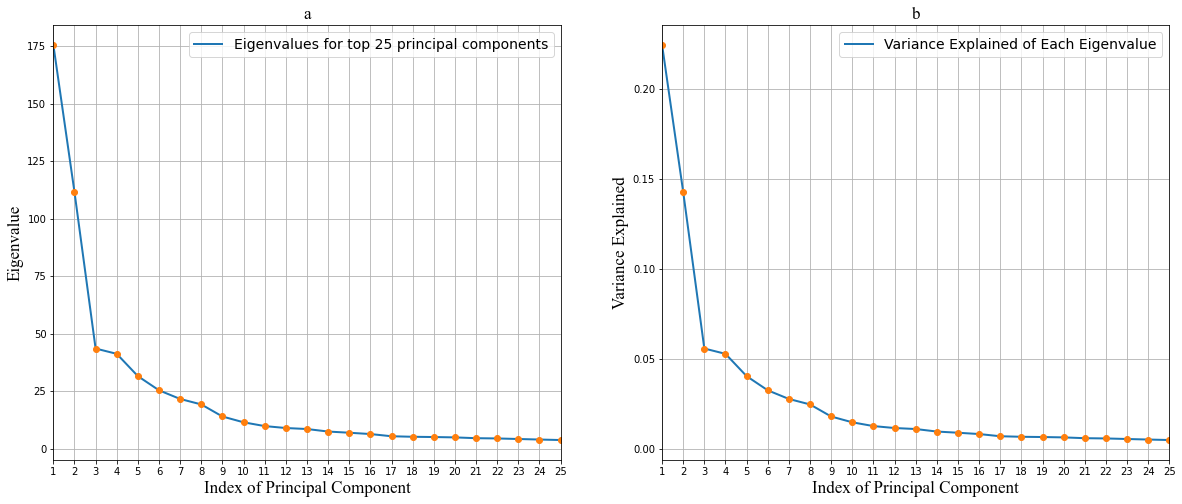

In [171]:
C = 1.0/(len(X)-1) * np.dot(X.T, X)
all_eigenvalues, _ = np.linalg.eig(C)
total_variance = abs(all_eigenvalues.sum())

explained_variances = eigenvalues /  total_variance
# print('The explained variance for the top {} principle components is: {}'.format(k, explained_variances))

from matplotlib.ticker import FormatStrFormatter
params = {'legend.fontsize': 14}
plt.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
fig, axs = plt.subplots(1, 2, figsize=(20,8))
x_axis = np.linspace(1, 25, 25)
axs[0].set_title('a', fontname='Times New Roman', fontsize=17)
axs[0].plot(x_axis, eigenvalues, label='Eigenvalues for top {} principal components'.format(m), linewidth=2)
axs[0].plot(x_axis, eigenvalues, 'o')
axs[0].set_xlabel('Index of Principal Component', fontname='Times New Roman', fontsize=17)
axs[0].set_ylabel('Eigenvalue', fontname='Times New Roman', fontsize=17)
axs[0].set_xticks(x_axis)
axs[0].set_xlim(1, x_axis[-1])
# axs[0].set_ylim(0.25, 2.5)
axs[0].legend()
axs[0].grid()
axs[1].set_title('b', fontname='Times New Roman', fontsize=17)
axs[1].plot(x_axis, explained_variances, label='Variance Explained of Each Eigenvalue', linewidth=2)
axs[1].plot(x_axis, explained_variances, 'o')
axs[1].set_xlabel('Index of Principal Component', fontname='Times New Roman', fontsize=17)
axs[1].set_ylabel('Variance Explained', fontname='Times New Roman', fontsize=17)
axs[1].set_xticks(x_axis)
axs[1].set_xlim(1, x_axis[-1])
# axs[1].set_ylim(0, 1)
axs[1].legend()
axs[1].grid()
plt.show()

<a name="q213"></a>

#### Task 2.1.3 [^](#outline)

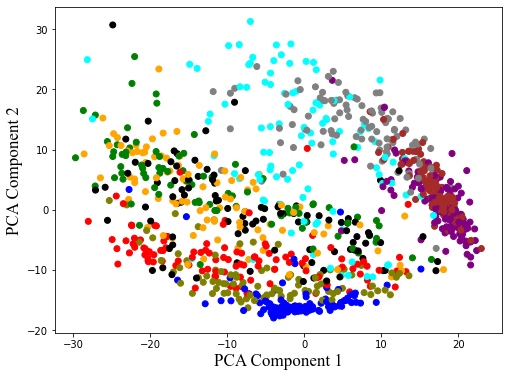

In [118]:
from matplotlib.ticker import FormatStrFormatter
params = {'legend.fontsize': 14}
plt.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'

classes = y_train.copy()[:1000]
colors = ['red', 'blue', 'green', 'olive', 'orange', 'purple', 'black', 'brown', 'cyan', 'gray']
class_colors = [colors[np.argmax(y)] for y in classes]

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=class_colors)
plt.xlabel('PCA Component 1', fontname='Times New Roman', fontsize=17)
plt.ylabel('PCA Component 2', fontname='Times New Roman', fontsize=17)
plt.show()

<a name="q214"></a>

#### Task 2.1.4 [^](#outline)

In [127]:
m_optimum = 2
# compute the projection, the eigenvector and eigenvalues from our function
X_pca_optimum, eigenvectors_optimum, eigenvalues_optimum = pca_function(X, m_optimum) 

n_samples, n_features = X_pca_optimum.shape

# number of clusters k
ks = np.linspace(2, 10, 9)

In [167]:
np.random.seed(123)

Ws = []
for k in ks:
    k = int(k)
    labels = np.random.randint(low=0, high=k, size=n_samples)
    X_labels = np.append(X_pca_optimum, labels.reshape(-1,1), axis=1)

    # computing the centroids of each of the k clusters
    centroids = np.zeros((k, n_features))
    for i in range(k):
        centroids[i] = np.mean([x for x in X_labels if x[-1]==i], axis=0)[0:n_features]
        
    max_iter = 40
    new_labels = np.zeros(len(X_pca_optimum))
    difference = 0

    w = []
    # k-means algorithm
    for i in range(max_iter):
        # distances: between data points and centroids
        distances = np.array([np.linalg.norm(X_pca_optimum - c, axis=1) for c in centroids])
        # new_labels: computed by finding centroid with minimal distance
        new_labels = np.argmin(distances, axis=0)

        if (labels==new_labels).all():
            # labels unchanged
            labels = new_labels
            for c in range(k):
                w.append(np.power(X_pca_optimum[labels==c] - centroids[c], 2).sum())
            break
        else:
            # labels changed
            # difference: percentage of changed labels
            difference = np.mean(labels!=new_labels)
            labels = new_labels
            for c in range(k):
                # update centroids by taking the mean over associated data points
                if (labels == c).any():
                    centroids[c] = np.mean(X_pca_optimum[labels==c], axis=0)
    Ws.append(np.sum(w))
    print('k={}, W={}'.format(k, Ws[k-2]))

k=2, W=157929.64802880777
k=3, W=94158.79964224427
k=4, W=62804.36141827285
k=5, W=49722.588486013905
k=6, W=41433.56313708532
k=7, W=36620.28020107332
k=8, W=29027.49697157505
k=9, W=26130.85724240888
k=10, W=23438.035822628193


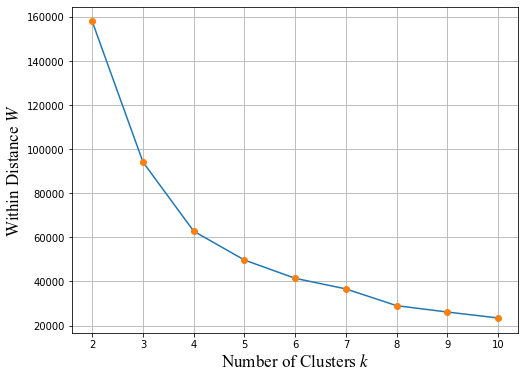

In [169]:
from matplotlib.ticker import FormatStrFormatter
params = {'legend.fontsize': 14}
plt.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'

plt.figure(figsize=(8,6))
plt.plot(ks, Ws)
plt.plot(ks, Ws, 'o')
plt.xlabel('Number of Clusters ' + r'$k$', fontname='Times New Roman', fontsize=17)
plt.ylabel('Within Distance ' + r'$W$', fontname='Times New Roman', fontsize=17)
plt.grid()
plt.show()

Optimal value of $k$ is around 5, where increasing $k$ further doesn't result in any significant improvement in the clustering.

<a name="q22"></a>

## 2.2 Clustering of the Feature Matrix [^](#outline)

<a name="q221"></a>

#### Task 2.2.1 [^](#outline)

In [183]:
import pandas as pd

dolphin_names = pd.read_csv('./CW2DATA/dolphin_names.csv').to_numpy()
adjacency_matrix = np.load('./CW2DATA/dolphins_A_62x62.npy', allow_pickle=True)
feature_matrix = np.load('./CW2DATA/dolphins_F_62x32.npy', allow_pickle=True)
print(dolphin_names.shape)  # Names of dolphins
print(adjacency_matrix.shape) # Adjacency matrix (NxN)
print(feature_matrix.shape)  # Feature matrix (Nxp) --> set of of p=32 features for each dolphin

(62, 2)
(62, 62)
(62, 32)


In [184]:
def pairwise_distances(points):
    '''
    Args:
        points: A numpy array of points having the shape (N, D), 
          where N is the number of points and D is the number of features.
    Returns:
        A numpy array with shape (N, N) such that the element (i, j) is the computed
        distance between i-th point and j-th point in X.
    '''
    N, D = points.shape
    distance = np.empty((N, N))
    
    # distance matrix will be symmetric, so avoid redundant computations.
    for i in range(N):
        distance[i, i] = 0
        for j in range(i + 1, N):
            d = np.sqrt(np.power(points[i, :] - points[j, :], 2).sum())
            distance[i, j] = d
            distance[j, i] = d
            
    return distance

In [187]:
d = pairwise_distances(feature_matrix)

In [185]:
def average_linkage(distances, cluster_assignment, i, j):
    """
    This function computes the average linkage value between two clusters.
    Args:
      distances: A numpy array of pair-wise distances for the given points.
      cluster_assignment: A 1-D numpy array that assigns a cluster id for every point.
      i: the first cluster id.
      j: the second cluster id.
    Returns:
      The average distance between the two given clusters.
    """
    # Select the point indices of the first cluster.
    points_i = np.argwhere(cluster_assignment == i)
    # Select the point indices of the second cluster.
    points_j = np.argwhere(cluster_assignment == j)
    # Form a cartesian product between the indices in i and indices in j.
    pairs = np.array([[element_i.item(), element_j.item()]  for element_i in points_i for element_j in points_j])
    # Select the pair distances between the points in the two clusters from the distances matrix.
    pairs_distance = distances[pairs[:, 0], pairs[:, 1]]
    # Return the average
    return pairs_distance.mean()

In [227]:
def hierarchical_clustering(points, distances, linkage):
    """
    The hierarchical clustering algorithm start with every point as a single cluster and 
    each iteration merges two clusters into one. We may wish to store all the 
    intermediate clustering results with respect to the number of clusters left.

    Args:
     points: A numpy array of points having the shape (N, D), 
          where N is the number of points and D is the number of features.
     distances: A numpy array with shape (N, N) such that the element (i, j) is the computed
        distance between i-th point and j-th point in X.
     linkage: A linkage function from the above to call to compute the linkage values between two clusters.

    Returns:
     A numpy array of shape (N, N) of which each row stores the clustering assignment at each level.
     The first row, i.e. a[0, :], represents the highest level of clustering where all columns have the same index value.
     The second row, i.e. a[1, :], represents all the points assigned into two cluster indices.
     The last row, i.e. a[N - 1, :], represents the points assigned into N - 1 cluster indices.
    """ 
    N, D = points.shape
    assignments = np.zeros((N, N))
    
    # Begin with every point is its own cluster
    current_assignment = np.arange(N)
    
    # The id to be assigned for the next merged cluster
    next_cluster_id = N
    
    # Begin from level (N - 1) to level 1
    for level in range(N - 1, 0, -1):
        # if (level % 10) == 0:
            # print(f'level:{level}')
        cluster_ids = np.unique(current_assignment)
        
        min_d = np.inf
        
        # Initialize the cluster ids to be merged in this iteration.
        cluster_a, cluster_b = (-1, -1) 
        
        # Now find the two clusters that have the minimum distance in between.
        for i in range(cluster_ids.size):
            for j in range(i + 1, cluster_ids.size):
                cluster_i = cluster_ids[i]
                cluster_j = cluster_ids[j]
                d = linkage(distances, current_assignment, cluster_i, cluster_j)
                if d < min_d:
                    min_d = d
                    cluster_a, cluster_b = (cluster_i, cluster_j)
                    
        
        # Merge the two clusters
        current_assignment[(current_assignment == cluster_a) | (current_assignment == cluster_b)] = next_cluster_id
        next_cluster_id += 1
        # Store the current cluster assignment into the assignments array.
        assignments[level, :] = current_assignment
        
    return assignments

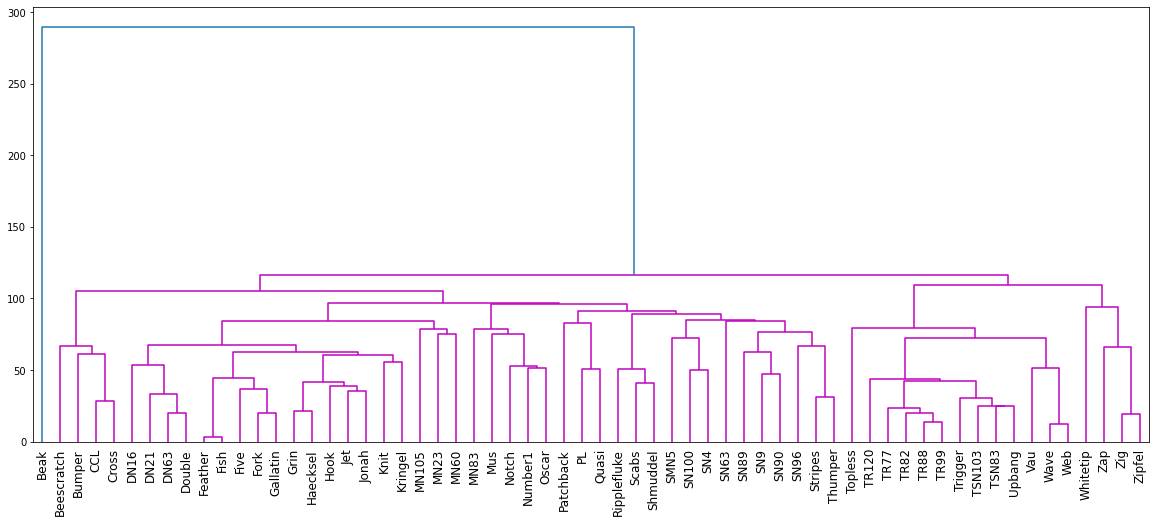

In [324]:
assignments = hierarchical_clustering(feature_matrix, d, average_linkage)

from scipy.cluster import hierarchy

Z = hierarchy.linkage(assignments)
plt.figure(figsize=(20,8))
dn = hierarchy.dendrogram(Z)
plt.xticks(plt.xticks()[0], dolphin_names[:,1], fontsize=12)
plt.show()

<a name="q222"></a>

#### Task 2.2.2 [^](#outline)

In [311]:
def silhouette_coefficient(feature_matrix, assignments, level, sample_index):
    sample_value = assignments[level][sample_index]

    sample_cluster_indices = [i for i in range(len(assignments[level])) if assignments[level][i] == sample_value and i!= sample_index]
    sample_cluster_features = [feature_matrix[idx] for idx in sample_cluster_indices]
    
    if len(sample_cluster_indices) == 0:
        d1 = 0
    else:
        d1 = np.mean([np.sqrt((feature_matrix[sample_index]-sample_cluster_features[i])**2) for i in range(len(sample_cluster_features))])
    
    other_clusters = list(set(np.unique(assignemnets[level])) - {sample_value})
    other_clusters_indices = [[i for i in range(len(assignments[level])) if assignments[level][i] == el and i!= sample_index] for el in other_clusters]
    other_clusters_features = [[feature_matrix[idx] for idx in other_cluster_indices] for other_cluster_indices in other_clusters_indices]

    d2 = min([np.mean([np.sqrt((feature_matrix[sample_index]-other_cluster_features[i])**2) for i in range(len(other_cluster_features))]) for other_cluster_features in other_clusters_features])

    if d1 == 0:
        silhouette_coeff = 0
    else:
        silhouette_coeff = (d2-d1)/max(d1, d2)
    
    return silhouette_coeff

In [304]:
def silhouette_score(feature_matrix, assignments):
    silhouette_scores = []
    for i in range(2, len(assignments)-1):
        total = 0
        for j in range(len(feature_matrix)):
            silhouette_coeff = silhouette_coefficient(feature_matrix, assignments, i, j)
            total += silhouette_coeff
        silhouette_scores.append(total/len(feature_matrix))
    return silhouette_scores

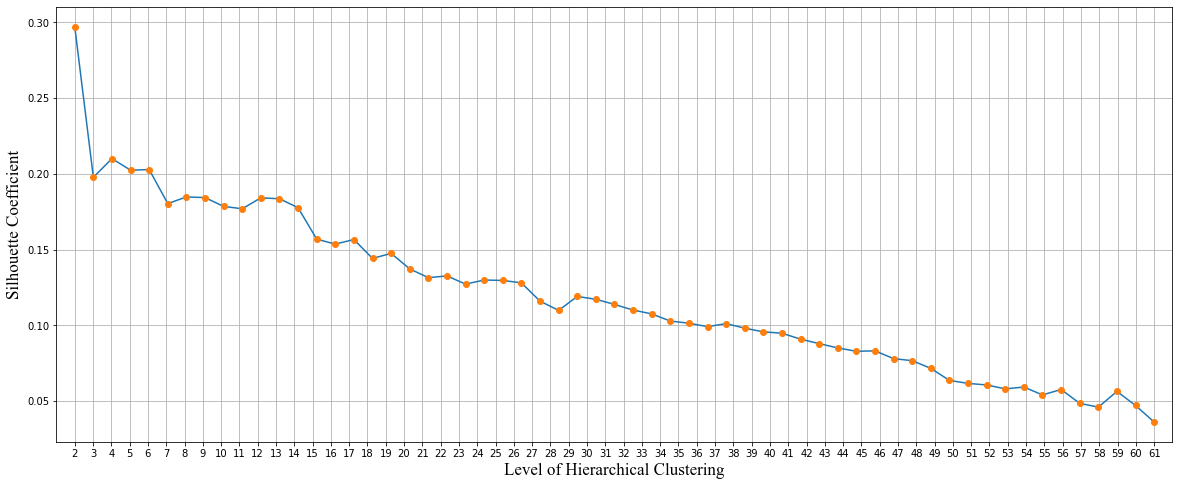

Optimal Silhouette Score at level 2


In [343]:
silhouette_scores = silhouette_score(feature_matrix, assignments)

from matplotlib.ticker import FormatStrFormatter
params = {'legend.fontsize': 14}
plt.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'

plt.figure(figsize=(20, 8))
plt.plot(np.linspace(2, len(assignments)-1, len(assignments)-3), silhouette_scores)
plt.plot(np.linspace(2, len(assignments)-1, len(assignments)-3), silhouette_scores, 'o')
plt.xlabel('Level of Hierarchical Clustering', fontname='Times New Roman', fontsize=17)
plt.ylabel('Silhouette Coefficient', fontname='Times New Roman', fontsize=17)
plt.xticks(np.linspace(2, len(assignments)-1, len(assignments)-2, dtype=int))
plt.xlim(1, 62)
plt.grid()
plt.show()

print('Optimal Silhouette Score at level {}'.format(int(np.linspace(2, len(assignments)-1, len(assignments)-3)[np.argmax(silhouette_scores)])))

<a name="q23"></a>

## 2.3 Graph-Based Analysis [^](#outline)

<a name="q231"></a>

#### Task 2.3.1 [^](#outline)

In [329]:
import networkx as nx
from matplotlib.colors import ListedColormap

from scipy.spatial.distance import cdist
from scipy.sparse import linalg

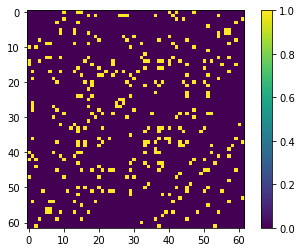

In [330]:
plt.imshow(adjacency_matrix)
plt.colorbar();

In [331]:
# compute the exponential of each negative matrix element
A = np.exp(-adjacency_matrix)

# fill the diagonal with zeros
np.fill_diagonal(A,0)

In [332]:
# set all edges below weight=0.3 to zero
A[A<0.3] = 0

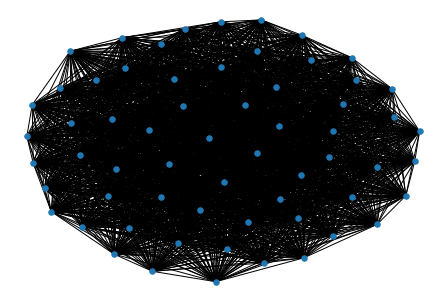

In [334]:
# constructing a networkx graph object
g = nx.Graph(A)

# drawing networkx graph
nx.draw(g, node_size=30)

In [335]:
# define diagonal matrix of node degrees
weighted_degree = A.sum(axis=1) 

# create diagonal matrix of degree
D = np.diag(weighted_degree)

In [337]:
# define Laplacian
L = D-A

# computing inverse square root vector of degree
weighted_degree_sqrt = 1.0 / np.sqrt(weighted_degree)

# set a diagonal matrix of the inverse square root of degree
D_inv_sqrt = np.diag(weighted_degree_sqrt)

# define the normalised Laplacian
L_norm = np.eye(A.shape[0]) - D_inv_sqrt.dot(A.dot(D_inv_sqrt))

In [338]:
# return the smallest magnitude eigenvectors and eigenvalues
eigenvals, eigenvecs = linalg.eigsh(L_norm, 2, which="SM", return_eigenvectors=True)

In [359]:
# printing the eigenvalues
print('The first eigenalue is: {}'.format(eigenvals[0]))
print('The second eigenalue is: {}'.format(eigenvals[1]))
print('The first eigenvector is: {}'.format(eigenvecs[0]))
print('The second eigenvector is: {}'.format(eigenvecs[1]))

The first eigenalue is: -8.993886114275056e-17
The second eigenalue is: 0.9753451795544363
The first eigenvector is: [0.12639339 0.11666175]
The second eigenvector is: [0.12498898 0.09458365]


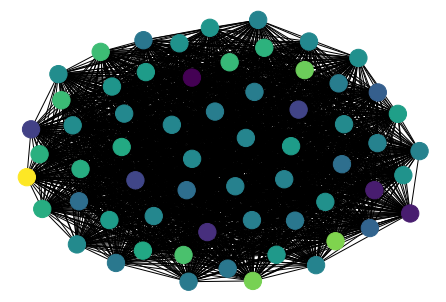

In [340]:
# extract the second eigenvector
second_eigenvector = eigenvecs[:,1]

# draw the network structure coloured by the second eigenvector
nx.draw(g, node_color=second_eigenvector)

<a name="q232"></a>

#### Task 2.3.2 [^](#outline)

Degree Centrality

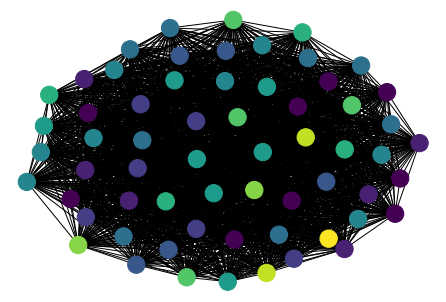

In [368]:
degree_centrality = adjacency_matrix.sum(axis=1)

# draw the degree distribution
nx.draw(g, node_color=degree_centrality)

Eigenvector Centrality

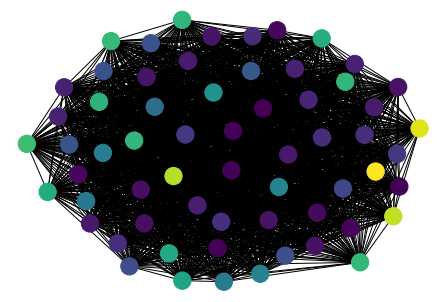

In [381]:
# compute the eigenvector associated with the largest eigenvalue
eigenvalue, eigenvector = linalg.eigsh(adjacency_matrix, 1, which="LM", return_eigenvectors=True)

# draw the eigenvector centrality
nx.draw(g, node_color=eigenvector)

Pagerank Centrality

Comparing Centralities

<a name="task-3"></a>

# Task 3: Mastery Component [^](#outline)

<a name="q31"></a>

## 3.1 Non-Negative Matrix Factorization (NMF) for Dimensionality Reduction [^](#outline)

<a name="q311"></a>

#### Task 3.1.1 [^](#outline)

In [353]:
nmf_images = x_train.copy()[:1000]

In [354]:
def normalize_nmf(X):
    X_norm = (X- np.min(X)) / (np.max(X) - np.min(X))
    return X_norm

In [355]:
nmf_images = normalize_nmf(nmf_images)

In [385]:
# choosing the number of dimensions on which to project
m=10

# setting the random seed (just so everyone gets the same results...)
np.random.seed(0)

# m x k components matrix, usually interpreted as the coefficients, where m is the number of data
W = np.random.rand(nmf_images.shape[0], m)

# k x n matrix interpreted as the basis set, where n is the number of features (e.g. pixels)
H = np.random.rand(m, nmf_images.shape[1])

In [386]:
# lets define a cost matrix to compare the difference
def cost(X, W, H):
  
    # compute the difference between X and the dot product of W and H
    diff = X - np.dot(W, H) ## <-- SOLUTION

    chi2 = ((X*diff) * diff).sum() / (X.shape[0]*X.shape[1])
    
    return chi2

In [387]:
# set the number of iterations
n_iters = 500

# empty list for chi2 
chi2 = []

# loop over the n iterations
for i in range(n_iters):
    # compute the update on H
    H = H * ((W.T.dot(nmf_images)) / W.T.dot(W.dot(H)))

    # compute the update on W
    W = W * ((nmf_images.dot(H.T)) / (W.dot(H.dot(H.T))))

    # compute the chi2 and append to list
    chi2.append(cost(nmf_images, W, H))

ValueError: shapes (10,1000) and (1000,28,28) not aligned: 1000 (dim 1) != 28 (dim 1)

In [ ]:
from matplotlib.ticker import FormatStrFormatter
params = {'legend.fontsize': 14}
plt.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'

plt.figure(figsize=(20, 8))
plt.plot(np.linspace(1, n_iters, n_iters), chi2)
plt.xlabel('Iteration', fontname='Times New Roman', fontsize=17)
plt.ylabel(r'$\chi^2$', fontname='Times New Roman', fontsize=17)
plt.xticks(np.linspace(1, n_iters, n_iters, dtype=int))
plt.grid()
plt.show()

<a name="q312"></a>

#### Task 3.1.2 [^](#outline)

<a name="q32"></a>

## 3.2 Community Detection [^](#outline)

<a name="q331"></a>

#### Task 3.2.1 [^](#outline)

In [388]:
import networkx.algorithms.community as nx_comm

nx_comm.louvain_communities(adjacency_matrix, seed=123)

AttributeError: module 'networkx.algorithms.community' has no attribute 'louvain_communities'

<a name="q322"></a>

#### Task 3.2.2 [^](#outline)